In [1]:
### import necessary packages
import uproot
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import time
from tqdm import tqdm
from itertools import permutations, product, combinations, chain
import glob


from joblib import Parallel, delayed
import multiprocessing

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,9)

In [2]:
## small easy helper functions
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)  # allows duplicate elements
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

# empiric energy resolution
def energy_resolution(energy,a=30.98,b=0.37):
    res_rel = np.divide(a,np.sqrt(energy))+b
    res_abs = energy * res_rel/100
    return res_abs #returns absolute energy



In [3]:
### transforms a root file in a single index file
### had issues reading out the multiindex file although I think this is the way to go for an optimized script
### the function also sorts in zp for the further analysis
def transform_root_file_and_sort_by_z(filename):
    events=uproot.open(filename)["events"]
    events2=events["events"]# why do I have to do that
    df =  events2.pandas.df(["ed", "zp","xp","yp","trackid","parentid","etot"]) # make a pandas data frame with the parameters of interest
    df2 = df.sort_values('zp', ascending=False).sort_index(level='entry', sort_remaining=False) # sort by z
    df3 = df2.reset_index(level="entry") # remove multiindex1
    final_df = df3.reset_index(level="subentry") # remove multiindex2
    return final_df

In [4]:
### in progress
### toDO: x,y is not sorted. So there may be events which bounce crazy and cause problems if they are at the same z, this has to be checked
### toDO: the first event is dead on arrival, just use N-1 for later analysis

def get_data_frame_with_summed_energy_xy(df,z_res,xy_res,no_of_events=10000):
    energy_in_one = 0
    energy_list = []
    event_list = []
    energy_tot_list = []
    data_frame = df[df["entry"].between(0,no_of_events)] # this works since we have the tot column all the same within one evt_id

    
    for j in data_frame.index:
        if(j>0 and j<(len(data_frame))):
            if  (data_frame.at[j,"entry"]==data_frame.at[j-1,"entry"] 
            and ((np.abs(data_frame.at[j-1,"zp"]-data_frame.at[j,"zp"])<z_res))
            and ((np.abs(data_frame.at[j-1,"xp"]-data_frame.at[j,"xp"])<xy_res)) 
            and ((np.abs(data_frame.at[j-1,"yp"]-data_frame.at[j,"yp"])<xy_res))):
                            energy_in_one+=data_frame.at[j,"ed"]
            elif(data_frame.at[j,"entry"]!=data_frame.at[j+1,"entry"]) :
                    energy_list.append(energy_in_one)
                    event_list.append(data_frame.at[j,"entry"])
                    energy_tot_list.append(data_frame.at[j,"etot"])
                    energy_in_one = data_frame.at[j,"ed"]    
            else:   # if resolveable, write out the energy summed so far                    
                    energy_list.append(energy_in_one)
                    event_list.append(data_frame.at[j-1,"entry"])
                    energy_tot_list.append(data_frame.at[j-1,"etot"])
                    energy_in_one = data_frame.at[j,"ed"] # j is the stored energy. The results look alright, but does this make problems in border cases?
                
        #else  print(j)
            
    df_new_with_xy  = pd.DataFrame() # make a new dataframe to fill with results (ladies and gentlemen, mr.inefficient)
    df_new_with_xy ["event_id"] = event_list # the event_id
    df_new_with_xy ["energy"] = energy_list # the energy
    df_new_with_xy ["etot"] = energy_tot_list # the total energy deposition, important for cuts later but also cross check 
    return df_new_with_xy    

In [5]:
### OUTDATED: use with fv instead
### toDO: x,y is not sorted. So there may be events which bounce crazy and cause problems if they are at the same z, this has to be checked
### toDO: the first event is dead on arrival, just use N-1 for later analysis

def get_data_frame_with_summed_preselected_energy_xy(df,z_res,xy_res,decay,no_of_events=10000):
    energy_in_one = 0
    energy_list = []
    event_list = []
    energy_tot_list = []
    data_frame = df[df["entry"].between(0,no_of_events)] # this works since we have the tot column all the same within one evt_id
    if(decay=="2vECB+"): 
        data_frame = data_frame[data_frame["etot"].between(31-energy_resolution(31,30.98,0.37)+1022-energy_resolution(1022,30.98,0.37),2856+energy_resolution(2856,30.98,0.37))] # this works since we have the tot column all the same within one evt_id
    elif(decay=="2vB+B+"): 
        data_frame = data_frame[data_frame["etot"].between(31-energy_resolution(31,30.98,0.37)+2044-energy_resolution(2044,30.98,0.37),2856+energy_resolution(2856,30.98,0.37))] # this works since we have the tot column all the same within one evt_id      
    elif(decay=="0vECB+" or decay=="0vB+B+" or decay=="0vECEC" or decay=="0vECEC_2" or decay=="0vECB+_new" ):
        ## first we want only events which left the entire energy in the detetor
        data_frame = data_frame[data_frame["etot"].between(2856-energy_resolution(2856,30.98,0.37),2856+energy_resolution(2856,30.98,0.37))] # this works since we have the tot column all the same within one evt_id
    data_frame = data_frame.reset_index()
    #print(data_frame.head())
    for j in data_frame.index:
        #print(j)
        if(j>0 and j<(len(data_frame))):
            #print(data_frame.at[j,"entry"])
            if  (data_frame.at[j,"entry"]==data_frame.at[j-1,"entry"] 
            and ((np.abs(data_frame.at[j-1,"zp"]-data_frame.at[j,"zp"])<z_res))
            and ((np.abs(data_frame.at[j-1,"xp"]-data_frame.at[j,"xp"])<xy_res)) 
            and ((np.abs(data_frame.at[j-1,"yp"]-data_frame.at[j,"yp"])<xy_res))):
                            energy_in_one+=data_frame.at[j,"ed"]
            elif(data_frame.at[j,"entry"]!=data_frame.at[j+1,"entry"]) :
                    energy_list.append(energy_in_one)
                    event_list.append(data_frame.at[j,"entry"])
                    energy_tot_list.append(data_frame.at[j,"etot"])
                    energy_in_one = data_frame.at[j,"ed"]    
            else:   # if resolveable, write out the energy summed so far                    
                    energy_list.append(energy_in_one)
                    event_list.append(data_frame.at[j-1,"entry"])
                    energy_tot_list.append(data_frame.at[j-1,"etot"])
                    energy_in_one = data_frame.at[j,"ed"] # j is the stored energy. The results look alright, but does this make problems in border cases?
                
        #else  print(j)
            
    df_new_with_xy  = pd.DataFrame() # make a new dataframe to fill with results (ladies and gentlemen, mr.inefficient)
    df_new_with_xy ["event_id"] = event_list # the event_id
    df_new_with_xy ["energy"] = energy_list # the energy
    df_new_with_xy ["etot"] = energy_tot_list # the total energy deposition, important for cuts later but also cross check 
    return df_new_with_xy    

In [6]:
### toDO: x,y is not sorted. So there may be events which bounce crazy and cause problems if they are at the same z, this has to be checked
### toDO: the first event is dead on arrival, just use N-1 for later analysis

def get_data_frame_with_summed_preselected_energy_xy_and_fv(df,z_res,xy_res,decay,fv,no_of_events=10000):
    energy_in_one = 0
    energy_list = []
    event_list = []
    energy_tot_list = []
    data_frame = df[df["entry"].between(0,no_of_events)] # this works since we have the tot column all the same within one evt_id
    if(decay=="2vECB+"): 
        data_frame = data_frame[data_frame["etot"].between(31-energy_resolution(31,30.98,0.37)+1022-energy_resolution(1022,30.98,0.37),2856+energy_resolution(2856,30.98,0.37))] # this works since we have the tot column all the same within one evt_id
    elif(decay=="2vB+B+"): 
        data_frame = data_frame[data_frame["etot"].between(31-energy_resolution(31,30.98,0.37)+2044-energy_resolution(2044,30.98,0.37),2856+energy_resolution(2856,30.98,0.37))] # this works since we have the tot column all the same within one evt_id      
    elif(decay=="0vECB+" or decay=="0vB+B+" or decay=="0vECEC" or decay=="0vECEC_2" or decay=="0vECB+_new" ):
        ## first we want only events which left the entire energy in the detetor
        data_frame = data_frame[data_frame["etot"].between(2856-energy_resolution(2856,30.98,0.37),2856+energy_resolution(2856,30.98,0.37))] # this works since we have the tot column all the same within one evt_id
    data_frame = data_frame.reset_index()
    
    
    ### FV, works but looks ugly. Why did between not work in a single argument
    df = data_frame
    list_index=[]
    cut_criteria= df["zp"].between(np.min(df.zp),np.min(df.zp)+fv)
    list_index=df[cut_criteria]['entry']
    df=df[~df['entry'].isin(list_index)]
    cut_criteria= df["zp"].between(np.max(df.zp)-fv,np.max(df.zp))
    list_index=df[cut_criteria]['entry']
    df=df[~df['entry'].isin(list_index)]
    #print(len(np.unique(df.entry)),"4")
    cut_criteria= df["xp"].between(np.min(df.xp),np.min(df.xp)+fv)
    list_index=df[cut_criteria]['entry']
    df=df[~df['entry'].isin(list_index)]
    cut_criteria= df["xp"].between(np.max(df.xp)-fv,np.max(df.xp))
    list_index=df[cut_criteria]['entry']
    df=df[~df['entry'].isin(list_index)]
    #print(len(np.unique(df.entry)))
    cut_criteria= df["yp"].between(np.min(df.yp),np.min(df.yp)+fv)
    list_index=df[cut_criteria]['entry']
    df=df[~df['entry'].isin(list_index)]
    cut_criteria= df["yp"].between(np.max(df.yp)-fv,np.max(df.yp))
    list_index=df[cut_criteria]['entry']
    df=df[~df['entry'].isin(list_index)]
    #print(len(np.unique(df.entry)))
    data_frame = df
    data_frame = data_frame.reset_index()

    
    #print(data_frame.head())
    for j in data_frame.index:
        #print(j)
        if(j>0 and j<(len(data_frame))):
            try:
                #print(data_frame.at[j,"entry"])
                if  (data_frame.at[j,"entry"]==data_frame.at[j-1,"entry"] 
                and ((np.abs(data_frame.at[j-1,"zp"]-data_frame.at[j,"zp"])<z_res))
                and ((np.abs(data_frame.at[j-1,"xp"]-data_frame.at[j,"xp"])<xy_res)) 
                and ((np.abs(data_frame.at[j-1,"yp"]-data_frame.at[j,"yp"])<xy_res))):
                                energy_in_one+=data_frame.at[j,"ed"]
                elif(data_frame.at[j,"entry"]!=data_frame.at[j+1,"entry"]) :
                        energy_list.append(energy_in_one)
                        event_list.append(data_frame.at[j,"entry"])
                        energy_tot_list.append(data_frame.at[j,"etot"])
                        energy_in_one = data_frame.at[j,"ed"]    
                else:   # if resolveable, write out the energy summed so far
                        energy_list.append(energy_in_one)
                        event_list.append(data_frame.at[j-1,"entry"])
                        energy_tot_list.append(data_frame.at[j-1,"etot"])
                        energy_in_one = data_frame.at[j,"ed"] # j is the stored energy. The results look alright, but does this make problems in border cases?
            except:         
                print("Did not %d work" %j)
                continue  
        #else  print(j)
            
    df_new_with_xy  = pd.DataFrame() # make a new dataframe to fill with results (ladies and gentlemen, mr.inefficient)
    df_new_with_xy ["event_id"] = event_list # the event_id
    df_new_with_xy ["energy"] = energy_list # the energy
    df_new_with_xy ["etot"] = energy_tot_list # the total energy deposition, important for cuts later but also cross check 
    return df_new_with_xy    

In [9]:
def get_number_of_scatter(data_frame,number_of_events=10000,multiplicity=2): # number of events can be set by the length of your file (toDO: it may need a correction by 2), multiplicity is simply how many scatter you want
    scatter_list = [] # I love lists apparently
    fraction_above_multi = 0 # will be the final value for the fraction above a certain multiplicity
    for i in np.arange(0,data_frame.at[data_frame.index[-1], 'event_id']):
        scatter_list.append(len(data_frame[data_frame['event_id'] == i]))
    ## list comprehension below, isn't faster
    #different_num = [len(df_new[df_new['event_id'] == i]) for i in np.arange(0,df_new.at[df_new.index[-1], 'event_id'])]
    fraction_above_multi = np.divide(np.count_nonzero(np.asarray(scatter_list)>(multiplicity-1)),number_of_events) # just count all events above a certain multiplicity and calculate a ratio to the total events
    return fraction_above_multi

In [10]:
def energy_selection(df,energy_list_no_permu,energy_list,e_res1=30.98,e_res2=0.37,threshold_energy=250,threshold=True):
   
       """
       This is the script to use for all neutrinoless modes
       """

    ### pre-filtering according to the threshold:
    if(threshold==True):
        list_index=[]
        cut_criteria= df["energy"].between(0.01,threshold_energy)
        list_index=df[cut_criteria]['energy']
        df=df[~df['energy'].isin(list_index)]             # remove all entries below threshold                
        sum_list =[]
        for event_id in df["event_id"]: 
            sum_list.append(df[df["event_id"]==event_id].sum()["energy"]) 
        df["real_energy"]=sum_list # add a real energy variable which will be used if threshold is applicable
        energy_cut_var = "real_energy" 
    if(threshold==False):energy_cut_var="etot" # else use the Geant4 var
                             
        
    df = df[df[energy_cut_var].between(2856-energy_resolution(2856,30.98,0.37),2856+energy_resolution(2856,30.98,0.37))] # this works since we have the tot column all the same within one evt_id
    #print(energy_list_no_permu)
    for n in energy_list_no_permu:
        #print(n-energy_resolution(n,e_res1,e_res2),n+energy_resolution(n,e_res1,e_res2))
        df_temp = df[df["energy"].between(n-energy_resolution(n,e_res1,e_res2),n+energy_resolution(n,e_res1,e_res2))] # this works since we have the tot column all the same within one evt_id
        df = df[df.event_id.isin(df_temp.event_id)]
    df_perm = df
    loop_group = df_perm.groupby("event_id") # group them by event id
    list_index6 = [] # make some more lists
    list_index7= [] # oh yeah 
    list_index8 = [] # list it to me baby
    list_index9 = []
    debug_list = []
    removal_list = [] # last one, I promise
    for i in np.unique(df_perm.event_id): # now check all event ids in the dataframe
        counter = 0
        large_counter = 0
        #print(i)
        if(i>0):                
            if(len(loop_group.get_group(i))>16):
                    print("too large")
                    large_counter+=1
            if(len(loop_group.get_group(i))>=len(energy_list) and len(loop_group.get_group(i))<17):

                #print(len(loop_group.get_group(i)),i)
                loop_group.get_group(i) # and look into the values
                list_index7 = list(combinations(loop_group.get_group(i).energy,1)) # build a list of all possible combinations of energy given the event_id
                for element,energy_entry in enumerate(list_index7):
                    for m in energy_list_no_permu:
                        if(np.sum(energy_entry)>(m-energy_resolution(m,e_res1,e_res2)) 
                           and np.sum(energy_entry)<(m+energy_resolution(m,e_res1,e_res2))):
                            list_index7.remove(energy_entry)
                for k in np.arange(0,len(energy_list),1):
                    #print(counter, k)
                    combo_list = []
                    entry_list = []
                    sum_list=[]
                    #print(list_index7)
                    for j, combo in enumerate(powerset(list_index7), 1): # powerset now goes from single entries to combinations of all entries
                        if(np.sum(combo)>(energy_list[k]-energy_resolution(energy_list[k],e_res1,e_res2)) 
                           and np.sum(combo)<(energy_list[k]+energy_resolution(energy_list[k],e_res1,e_res2))):
                            #print('combo', combo, np.sum(combo))
                            sum_list.append(np.abs(np.sum(combo)-energy_list[k]))
                            entry_list.append(j)
                            combo_list.append(combo)
                    if(len(sum_list)>0):
                        counter+=1
                        for select_values in combo_list[np.argmin(sum_list)]:
                            list_index7.remove(select_values)
            if(counter==len(energy_list)):
                #print('yes, here I am')
                list_index8.append(i)
    df_perm = df_perm[df_perm['event_id'].isin(list_index8)]  # filter the frame            
    df=df_perm 
    return df


In [11]:
### adding energy requirements ###

def energy_criteria_selection(df,decay,e_res1=30.98,e_res2=0.37,threshold_energy=250,threshold=True,permu=True):
    """
    contains legacy functions for old neutrinoless decays.
    still used for 2v modes
    """
    ### lets go through this complicated script using the positron example
    ### toDo: make it more modular
    ### toDo: and more generic, e.g. generic energy steps and just type them as an input (done for neutrinoless steps above)
    #print("here1")
    large_counter = 0
    ### pre-filtering according to the threshold:
    
    '''
    old threshold routine
    if(threshold==True):
        #print("here-1")
        list_index=[]
        cut_criteria= df["energy"].between(0.01,threshold_energy)
        list_index=df[cut_criteria]['event_id']
        df=df[~df['event_id'].isin(list_index)]                                   
    '''
    if(threshold==True):
        list_index=[]
        cut_criteria= df["energy"].between(0.01,threshold_energy)
        list_index=df[cut_criteria]['energy']
        df=df[~df['energy'].isin(list_index)]                             
        sum_list =[]
        for event_id in df["event_id"]:
            sum_list.append(df[df["event_id"]==event_id].sum()["energy"])
        df["real_energy"]=sum_list
        energy_cut_var = "real_energy"
    if(threshold==False):energy_cut_var="etot" 
    
    
    
    if(decay=="positron_1MeV_test"): # pick the decay of choice
        ## first we want only events which left the entire energy in the detetor
        df = df[df[energy_cut_var].between(2022-energy_resolution(2022,30.98,0.37),2022+energy_resolution(2022,30.98,0.37))] # this works since we have the tot column all the same within one evt_id
        ## second we want only events where the positron left its energy in one deposition
        criteria2 = df["energy"].between(1000-energy_resolution(1000,e_res1,e_res2),1000+energy_resolution(1000,e_res1,e_res2)) # careful: if resolution is able to separate the positron, a new algorithm would be needed
        criteria_sum = criteria2
        list_index2 = df[criteria_sum]["event_id"]
        df = df[df['event_id'].isin(list_index2)] 
        ## third lets go to 511 keV detection 
        
        if(permu==False):
        ## this mode requires an exact deposition of 511 keV (within energy resolution)
            df_mult = df[df["energy"].between(511-energy_resolution(511,e_res1,e_res2),511+energy_resolution(511,e_res1,e_res2))] # apply your criteria, here 511 keV depositions 
            list_index3 = df_mult["event_id"] # get all event_ids left so far
            list_index4=  df_mult.groupby('event_id')["energy"].count() # group the event_ids full_filling and count how often
            list_index5 = [] # create an empty list because you are AlexF the list fetish guy
            for i in list_index3.unique(): # check for all event_ids (but only once, hence the unique) if they fulfill the criteria
                if(list_index4[i]==2): # if the number of event_ids in the df_mult frame exceeds a certain number (here 1), save the event_id
                    list_index5.append(i)
            df = df[df['event_id'].isin(list_index5)] # now go back to your original dataframe and select only those events which have the respective multiple scatters

            
        if(permu==True): ## permutations are not the same as combinations but screw the name...
            ## okay tricky part starts here.
            ## Lets assume we start with the following energy combination: [1000,511,180,329,2]
            df_perm = df
            loop_group = df_perm.groupby("event_id") # group them by event id
            list_index6 = [] # make some more lists
            list_index7= [] # oh yeah 
            list_index8 = [] # list it to me baby
            list_index9 = [] # can"t have enough lists
            debug_list = [] # this one is not used any more
            removal_list = [] # last one, I promise

            for i in np.unique(df_perm.event_id): # now check all event ids in the dataframe
                counter = 0 # set a counter which keeps track of 511 keV depositions
                if(i>0):# get rid of event 0, it fails anyway
                    loop_group.get_group(i) # get event by event
                    if(len(loop_group.get_group(i))>2): # only do this if there is more than 2 entries
                        list_index7 = list(combinations(loop_group.get_group(i).energy,1)) # build a list of all possible combinations of energy given the event_id
                        #print(list_index7)
                        # do some pre-filtering to save computer time
                        for element,energy_entry in enumerate(list_index7): # loop through all entries
                            if(np.sum(energy_entry)>(511+energy_resolution(511,e_res1,e_res2))): # if an entry is above 511keV, no need to keep it as it won't help on the sum anyway
                                #print('remove because to high')
                                removal_list.append(energy_entry) # add the energy to the removal list
                                #this what we are left with: [511,180,329,2]
                            if(np.sum(energy_entry)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(energy_entry)<(511+energy_resolution(511,e_res1,e_res2))): # remove single 511 keV entries and count them
                               # print('remove since energy is already working but raise counter')
                                counter += 1 # raise the counter for each 511 keV deposition
                                removal_list.append(energy_entry) # but remove afterwards
                                #this what we are left with: [180,329,2]
                        list_index7=[x for x in list_index7 if x not in removal_list] # here the actual removing happens
                        #print(list_index7, 'filtered')
                        #print(counter)
                        list_index6=list(combinations(list_index7,len(list_index7))) # Here we get the combination of all remaining entries. This is done a bit stupid but I loved lists in this script 
                        #print(np.sum(list_index6))
                        if(counter>0 and np.sum(list_index6)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(list_index6)<(511+energy_resolution(511,e_res1,e_res2))): # if their is already a 511 keV entry and the remaining are 511 keV you are done (remember you have removed the positron)
                            counter += 1
                            # for our example this would be true and we were done. Let's pretend its not
                        if(counter>=2):
                            #print('counter high enough')
                            list_index8.append(i)    
                        combo_list = [] # haha you thought lists are over? Never. This one will contain possible cominbations
                        entry_list = [] # in retrospective I think I do not need that one, but a list is a list
                        sum_list=[] #the sum of all combos will be stored here - mhmm a list
                        for j, combo in enumerate(powerset(list_index7), 1): # powerset now goes from single entries to combinations of all entries
                            if(len(combo)>1 and np.sum(combo)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(combo)<(511+energy_resolution(511,e_res1,e_res2))): 
                                ## for non single entries and with the sum within the energy resolution check now how close they are to 511keV
                                #print('combo', combo, np.sum(combo))
                                sum_list.append(np.abs(np.sum(combo)-511))
                                entry_list.append(j)
                                combo_list.append(combo)
                                #print(np.abs(np.sum(combo)-511),j)
                        if(len(entry_list)>0):
                            counter +=1 # since we have something at 511, raise the counter
                            #print("value",entry_list[np.argmin(sum_list)],"somth",combo_list[np.argmin(sum_list)])
                        if(len(sum_list)>0): # but now we have to take care those energy entries are not re-used
                            for select_values in combo_list[np.argmin(sum_list)]:
                                list_index7.remove(select_values) # in our case this will be [180,329,2]
                                #print(list_index7,"now without")
                            if(counter>0 and np.sum(list_index7)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(list_index7)<(511+energy_resolution(511,e_res1,e_res2))): # so if the rest is 511 keV we are where we want to be
                                counter += 1 
                        if(counter>=2): # should be ==2, but redundancy prevents from failing this
                        #print('yes, here I am')
                            list_index8.append(i)
                    #print(len(list_index8))
                    #print(len(np.unique(list_index8)))
            df_perm = df_perm[df_perm['event_id'].isin(list_index8)]  # filter the frame            
            df=df_perm
             
    if(decay=="2vECB+"): 
            ## first we want only events which left the entire energy in the detetor
        df = df[df[energy_cut_var].between(31-energy_resolution(31,30.98,0.37)+1022-energy_resolution(1022,30.98,0.37),2856+energy_resolution(2856,30.98,0.37))] # this works since we have the tot column all the same within one evt_id
        ## second we want only events where the positron left its energy in one deposition
        criteria2 = df["energy"].between(0,1834+energy_resolution(1834,e_res1,e_res2)) # careful: if resolution is able to separate the positron, a new algorithm would be needed
        criteria_sum = criteria2
        list_index2 = df[criteria_sum]["event_id"]
        df = df[df['event_id'].isin(list_index2)]
        df_perm = df
        ## third we want to pick only those events where an algorithm would reconstruct 511 keV photons out of various energy depositions
        if(permu==False):
        ## can be used to filter for at least for full deposition
        ## may be faster to use this first, to get the obvious cases?
            df_mult = df[df["energy"].between(511-energy_resolution(511,e_res1,e_res2),511+energy_resolution(511,e_res1,e_res2))] # apply your criteria, here 511 keV depositions 
            list_index3 = df_mult["event_id"] # get all event_ids left so far
            list_index4=  df_mult.groupby('event_id')["energy"].count() # group the event_ids full_filling and count how often
            list_index5 = [] # create an empty list because you are AlexF the list fetish guy
            for i in list_index3.unique(): # check for all event_ids (but only once, hence the unique) if they fulfill the criteria
                if(list_index4[i]==2): # if the number of event_ids in the df_mult frame exceeds a certain number (here 1), save the event_id
                    list_index5.append(i)
            df = df[df['event_id'].isin(list_index5)] # now go back to your original dataframe and select only those events which have the respective multiple scatters

        if(permu==True): # permutations are not the same as combinations but screw the name...
            df_perm = df
            loop_group = df_perm.groupby("event_id") # group them by event id
            list_index6 = [] # make some more lists
            list_index7= [] # oh yeah 
            list_index8 = [] # list it to me baby
            list_index9 = []
            debug_list = []
            removal_list = [] # last one, I promise

            for i in np.unique(df_perm.event_id): # now check all event ids in the dataframe
                counter = 0
                if(i>0):                    
                    if(len(loop_group.get_group(i))>16):      
                        large_counter+=1
                        print(i,len(loop_group.get_group(i)),"TOOOO LONG") ## has to be done otherwise the permutation script part crashes. neglible
                    if(len(loop_group.get_group(i))>2 and len(loop_group.get_group(i))<17):
                        loop_group.get_group(i) # and look into the values
                        list_index7 = list(combinations(loop_group.get_group(i).energy,1)) # build a list of all possible combinations of energy given the event_id
                        #print(list_index7,i)
                        for element,energy_entry in enumerate(list_index7):
                            if(np.sum(energy_entry)>(511+energy_resolution(511,e_res1,e_res2))):
                                #print('remove because to high')
                                removal_list.append(energy_entry)
                            if(np.sum(energy_entry)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(energy_entry)<(511+energy_resolution(511,e_res1,e_res2))):
                               # print('remove since energy is already working but raise counter')
                                counter += 1
                                removal_list.append(energy_entry)
                        list_index7=[x for x in list_index7 if x not in removal_list]
                        #print(list_index7, 'filtered')
                        #print(counter)
                        list_index6=list(combinations(list_index7,len(list_index7)))
                        #print(np.sum(list_index6))
                        if(counter>0 and np.sum(list_index6)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(list_index6)<(511+energy_resolution(511,e_res1,e_res2))):
                            counter += 1
                        if(counter>=2):
                            #print('counter high enough')
                            list_index8.append(i)    
                        combo_list = []
                        entry_list = []
                        sum_list=[]
                        for j, combo in enumerate(powerset(list_index7), 1): # powerset now goes from single entries to combinations of all entries
                            if(len(combo)>1 and np.sum(combo)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(combo)<(511+energy_resolution(511,e_res1,e_res2))):
                                #print('combo', combo, np.sum(combo))
                                sum_list.append(np.abs(np.sum(combo)-511))
                                entry_list.append(j)
                                combo_list.append(combo)
                                #print(np.abs(np.sum(combo)-511),j)
                        if(len(entry_list)>0):
                            counter +=1
                            #print("value",entry_list[np.argmin(sum_list)],"somth",combo_list[np.argmin(sum_list)])
                        if(len(sum_list)>0):
                            for select_values in combo_list[np.argmin(sum_list)]:
                                list_index7.remove(select_values)
                                #print(list_index7,"now without")
                            if(counter>0 and np.sum(list_index7)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(list_index7)<(511+energy_resolution(511,e_res1,e_res2))):
                                counter += 1
                        if(counter>=2):
                        #print('yes, here I am')
                            list_index8.append(i)
                    #print(len(list_index8))
                    #print(len(np.unique(list_index8)))
            df_perm = df_perm[df_perm['event_id'].isin(list_index8)]  # filter the frame            
            df=df_perm
    
    if(decay=="0vECB+"):
        ## first we want only events which left the entire energy in the detetor
        df = df[df[energy_cut_var].between(2856-energy_resolution(2856,30.98,0.37),2856+energy_resolution(2856,30.98,0.37))] # this works since we have the tot column all the same within one evt_id
        ## second we want only events where the positron left its energy in one deposition
        criteria2 = df["energy"].between(1834-energy_resolution(1834,e_res1,e_res2),1834+energy_resolution(1834,e_res1,e_res2)) # careful: if resolution is able to separate the positron, a new algorithm would be needed
        criteria_sum = criteria2
        list_index2 = df[criteria_sum]["event_id"]
        df = df[df['event_id'].isin(list_index2)]
        df_perm = df
        ## third we want to pick only those events where an algorithm would reconstruct 511 keV photons out of various energy depositions
        if(permu==False):
        ## can be used to filter for at least for full deposition
        ## may be faster to use this first, to get the obvious cases?
            df_mult = df[df["energy"].between(511-energy_resolution(511,e_res1,e_res2),511+energy_resolution(511,e_res1,e_res2))] # apply your criteria, here 511 keV depositions 
            list_index3 = df_mult["event_id"] # get all event_ids left so far
            list_index4=  df_mult.groupby('event_id')["energy"].count() # group the event_ids full_filling and count how often
            list_index5 = [] # create an empty list because you are AlexF the list fetish guy
            for i in list_index3.unique(): # check for all event_ids (but only once, hence the unique) if they fulfill the criteria
                if(list_index4[i]==2): # if the number of event_ids in the df_mult frame exceeds a certain number (here 1), save the event_id
                    list_index5.append(i)
            df = df[df['event_id'].isin(list_index5)] # now go back to your original dataframe and select only those events which have the respective multiple scatters

        if(permu==True): # permutations are not the same as combinations but screw the name...
            df_perm = df
            loop_group = df_perm.groupby("event_id") # group them by event id
            list_index6 = [] # make some more lists
            list_index7= [] # oh yeah 
            list_index8 = [] # list it to me baby
            list_index9 = []
            debug_list = []
            removal_list = [] # last one, I promise

            for i in np.unique(df_perm.event_id): # now check all event ids in the dataframe
                counter = 0
                if(i>0):
                    if(len(loop_group.get_group(i))>16):
                        large_counter+=1
                        print(i,len(loop_group.get_group(i)),"TOOOO LONG") ## has to be done otherwise the permutation script part crashes. neglible
                    if(len(loop_group.get_group(i))>2 and len(loop_group.get_group(i))<17):
                        loop_group.get_group(i) # and look into the values
                        list_index7 = list(combinations(loop_group.get_group(i).energy,1)) # build a list of all possible combinations of energy given the event_id
                        #print(list_index7)
                        for element,energy_entry in enumerate(list_index7):
                            if(np.sum(energy_entry)>(511+energy_resolution(511,e_res1,e_res2))):
                                #print('remove because to high')
                                removal_list.append(energy_entry)
                            if(np.sum(energy_entry)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(energy_entry)<(511+energy_resolution(511,e_res1,e_res2))):
                               # print('remove since energy is already working but raise counter')
                                counter += 1
                                removal_list.append(energy_entry)
                        list_index7=[x for x in list_index7 if x not in removal_list]
                        #print(list_index7, 'filtered')
                        #print(counter)
                        list_index6=list(combinations(list_index7,len(list_index7)))
                        #print(np.sum(list_index6))
                        if(counter>0 and np.sum(list_index6)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(list_index6)<(511+energy_resolution(511,e_res1,e_res2))):
                            counter += 1
                        if(counter>=2):
                            #print('counter high enough')
                            list_index8.append(i)    
                        combo_list = []
                        entry_list = []
                        sum_list=[]
                        for j, combo in enumerate(powerset(list_index7), 1): # powerset now goes from single entries to combinations of all entries
                            if(len(combo)>1 and np.sum(combo)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(combo)<(511+energy_resolution(511,e_res1,e_res2))):
                                #print('combo', combo, np.sum(combo))
                                sum_list.append(np.abs(np.sum(combo)-511))
                                entry_list.append(j)
                                combo_list.append(combo)
                                #print(np.abs(np.sum(combo)-511),j)
                        if(len(entry_list)>0):
                            counter +=1
                            #print("value",entry_list[np.argmin(sum_list)],"somth",combo_list[np.argmin(sum_list)])
                        if(len(sum_list)>0):
                            for select_values in combo_list[np.argmin(sum_list)]:
                                list_index7.remove(select_values)
                                #print(list_index7,"now without")
                            if(counter>0 and np.sum(list_index7)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(list_index7)<(511+energy_resolution(511,e_res1,e_res2))):
                                counter += 1
                        if(counter>=2):
                        #print('yes, here I am')
                            list_index8.append(i)
                    #print(len(list_index8))
                    #print(len(np.unique(list_index8)))
            df_perm = df_perm[df_perm['event_id'].isin(list_index8)]  # filter the frame            
            df=df_perm 
        
    if(decay=="0vECB+_strict"):
## first we want only events which left the entire energy in the detetor
        df = df[df[energy_cut_var].between(2856-energy_resolution(2856,30.98,0.37),2856+energy_resolution(2856,30.98,0.37))] # this works since we have the tot column all the same within one evt_id
        ## second we want only events where the positron left its energy in one deposition
        criteria2 = df["energy"].between(1801-energy_resolution(1801,e_res1,e_res2),1801+energy_resolution(1801,e_res1,e_res2)) # careful: if resolution is able to separate the positron, a new algorithm would be needed
        criteria_sum = criteria2
        list_index2 = df[criteria_sum]["event_id"]
        df = df[df['event_id'].isin(list_index2)]
        criteria3 = df["energy"].between(31.8-energy_resolution(31.8,e_res1,e_res2),31.8+energy_resolution(31.8,e_res1,e_res2)) # careful: if resolution is able to separate the positron, a new algorithm would be needed
        criteria_sum = criteria3
        list_index2 = df[criteria_sum]["event_id"]
        df = df[df['event_id'].isin(list_index2)]
        df_perm = df
        ## third we want to pick only those events where an algorithm would reconstruct 511 keV photons out of various energy depositions
        if(permu==False):
        ## can be used to filter for at least for full deposition
        ## may be faster to use this first, to get the obvious cases?
            df_mult = df[df["energy"].between(511-energy_resolution(511,e_res1,e_res2),511+energy_resolution(511,e_res1,e_res2))] # apply your criteria, here 511 keV depositions 
            list_index3 = df_mult["event_id"] # get all event_ids left so far
            list_index4=  df_mult.groupby('event_id')["energy"].count() # group the event_ids full_filling and count how often
            list_index5 = [] # create an empty list because you are AlexF the list fetish guy
            for i in list_index3.unique(): # check for all event_ids (but only once, hence the unique) if they fulfill the criteria
                if(list_index4[i]==2): # if the number of event_ids in the df_mult frame exceeds a certain number (here 1), save the event_id
                    list_index5.append(i)
            df = df[df['event_id'].isin(list_index5)] # now go back to your original dataframe and select only those events which have the respective multiple scatters

        if(permu==True): # permutations are not the same as combinations but screw the name...
            df_perm = df
            loop_group = df_perm.groupby("event_id") # group them by event id
            list_index6 = [] # make some more lists
            list_index7= [] # oh yeah 
            list_index8 = [] # list it to me baby
            list_index9 = []
            debug_list = []
            removal_list = [] # last one, I promise

            for i in np.unique(df_perm.event_id): # now check all event ids in the dataframe
                counter = 0
                if(i>0):
                    if(len(loop_group.get_group(i))>16):
                        large_counter+=1
                        print(i,len(loop_group.get_group(i)),"TOOOO LONG") ## has to be done otherwise the permutation script part crashes. neglible
                    if(len(loop_group.get_group(i))>2 and len(loop_group.get_group(i))<17):
                        loop_group.get_group(i) # and look into the values
                        list_index7 = list(combinations(loop_group.get_group(i).energy,1)) # build a list of all possible combinations of energy given the event_id
                        #print(list_index7)
                        for element,energy_entry in enumerate(list_index7):
                            if(np.sum(energy_entry)>(511+energy_resolution(511,e_res1,e_res2))):
                                #print('remove because to high')
                                removal_list.append(energy_entry)
                            if(np.sum(energy_entry)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(energy_entry)<(511+energy_resolution(511,e_res1,e_res2))):
                               # print('remove since energy is already working but raise counter')
                                counter += 1
                                removal_list.append(energy_entry)
                        list_index7=[x for x in list_index7 if x not in removal_list]
                        #print(list_index7, 'filtered')
                        #print(counter)
                        list_index6=list(combinations(list_index7,len(list_index7)))
                        #print(np.sum(list_index6))
                        if(counter>0 and np.sum(list_index6)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(list_index6)<(511+energy_resolution(511,e_res1,e_res2))):
                            counter += 1
                        if(counter>=2):
                            #print('counter high enough')
                            list_index8.append(i)    
                        combo_list = []
                        entry_list = []
                        sum_list=[]
                        for j, combo in enumerate(powerset(list_index7), 1): # powerset now goes from single entries to combinations of all entries
                            if(len(combo)>1 and np.sum(combo)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(combo)<(511+energy_resolution(511,e_res1,e_res2))):
                                #print('combo', combo, np.sum(combo))
                                sum_list.append(np.abs(np.sum(combo)-511))
                                entry_list.append(j)
                                combo_list.append(combo)
                                #print(np.abs(np.sum(combo)-511),j)
                        if(len(entry_list)>0):
                            counter +=1
                            #print("value",entry_list[np.argmin(sum_list)],"somth",combo_list[np.argmin(sum_list)])
                        if(len(sum_list)>0):
                            for select_values in combo_list[np.argmin(sum_list)]:
                                list_index7.remove(select_values)
                                #print(list_index7,"now without")
                            if(counter>0 and np.sum(list_index7)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(list_index7)<(511+energy_resolution(511,e_res1,e_res2))):
                                counter += 1
                        if(counter>=2):
                        #print('yes, here I am')
                            list_index8.append(i)
                    #print(len(list_index8))
                    #print(len(np.unique(list_index8)))
            df_perm = df_perm[df_perm['event_id'].isin(list_index8)]  # filter the frame            
            df=df_perm 
        
    if(decay=="2vB+B+"):
        #print("here-1")
    ## first we want only events which left the entire energy in the detetor
        df = df[df[energy_cut_var].between(31-energy_resolution(31,e_res1,e_res2)+2044-energy_resolution(2044,30.98,0.37),2856+energy_resolution(2856,30.98,0.37))] # this works since we have the tot column all the same within one evt_id
        ## second we want only events where the positron left its energy in one deposition
        #print("here0")
        criteria2 = df["energy"].between(0,812+energy_resolution(812,e_res1,e_res2)) # careful: if resolution is able to separate the positron, a new algorithm would be needed
        criteria_sum = criteria2
        list_index2 = df[criteria_sum]["event_id"]
        df = df[df['event_id'].isin(list_index2)]
        
        #print("here1")
        df_prefilter = df[df["energy"].between(511+energy_resolution(511,e_res1,e_res2),812+energy_resolution(812,e_res1,e_res2))] # apply your criteria, here 511 keV depositions 
        list_p3 = df_prefilter["event_id"] # get all event_ids left so far
        list_p4=  df_prefilter.groupby('event_id')["energy"].count() # group the event_ids full_filling and count how often
        list_p5 = [] # create an empty list because you are AlexF the list fetish guy
        for i in list_p3.unique(): # check for all event_ids (but only once, hence the unique) if they fulfill the criteria
            if(list_p4[i]>1): # if the number of event_ids in the df_mult frame exceeds a certain number (here 1), save the event_id
                list_p5.append(i)
        #print(len(list_p5))        
        df = df[~df['event_id'].isin(list_p5)] # now go back to your original dataframe and select only those events which have the respective multiple scatters
        #print("here2")
        
        ## third we want to pick only those events where an algorithm would reconstruct 511 keV photons out of various energy depositions
        if(permu==False):
        ## can be used to filter for at least for full deposition
        ## may be faster to use this first, to get the obvious cases?
            df_mult = df[df["energy"].between(511-energy_resolution(511,e_res1,e_res2),511+energy_resolution(511,e_res1,e_res2))] # apply your criteria, here 511 keV depositions 
            list_index3 = df_mult["event_id"] # get all event_ids left so far
            list_index4=  df_mult.groupby('event_id')["energy"].count() # group the event_ids full_filling and count how often
            list_index5 = [] # create an empty list because you are AlexF the list fetish guy
            for i in list_index3.unique(): # check for all event_ids (but only once, hence the unique) if they fulfill the criteria
                if(list_index4[i]==4): # if the number of event_ids in the df_mult frame exceeds a certain number (here 1), save the event_id
                    list_index5.append(i)
            df = df[df['event_id'].isin(list_index5)] # now go back to your original dataframe and select only those events which have the respective multiple scatters
        
        if(permu==True): # permutations are not the same as combinations but screw the name...
            df_perm = df
            loop_group = df_perm.groupby("event_id") # group them by event id
            list_index6 = [] # make some more lists
            list_index7= [] # oh yeah 
            list_index8 = [] # list it to me baby
            list_index9 = []
            debug_list = []
            removal_list = [] # last one, I promise

            for i in np.unique(df_perm.event_id): # now check all event ids in the dataframe
                counter = 0
                if(i>0):
                    #print(i)
                    if(len(loop_group.get_group(i))>16):
                        large_counter+=1
                        print(i,len(loop_group.get_group(i)),"TOOOO LONG") ## has to be done otherwise the permutation script part crashes. neglible
                    if(len(loop_group.get_group(i))>2 and len(loop_group.get_group(i))<17):
                        loop_group.get_group(i) # and look into the values
                        list_index7 = list(combinations(loop_group.get_group(i).energy,1)) # build a list of all possible combinations of energy given the event_id
                        #print(list_index7)
                        for element,energy_entry in enumerate(list_index7):
                            if(np.sum(energy_entry)>(511+energy_resolution(511,e_res1,e_res2))):
                                #print('remove because to high')
                                removal_list.append(energy_entry)
                            if(np.sum(energy_entry)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(energy_entry)<(511+energy_resolution(511,e_res1,e_res2))):
                               # print('remove since energy is already working but raise counter')
                                counter += 1
                                removal_list.append(energy_entry)
                        list_index7=[x for x in list_index7 if x not in removal_list]
                        #print(list_index7, 'filtered')
                        #print(counter)
                        list_index6=list(combinations(list_index7,len(list_index7)))
                        #print(np.sum(list_index6))
                        if(counter>0 and np.sum(list_index6)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(list_index6)<(511+energy_resolution(511,e_res1,e_res2))):
                            counter += 1
                        if(counter==4):
                            #print('counter high enough')
                            list_index8.append(i)    
                        for k in np.arange(0,4,1):
                            combo_list = []
                            entry_list = []
                            sum_list=[]
                            for j, combo in enumerate(powerset(list_index7), 1): # powerset now goes from single entries to combinations of all entries
                                if(len(combo)>1 and np.sum(combo)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(combo)<(511+energy_resolution(511,e_res1,e_res2))):
                                        #print('combo', combo, np.sum(combo))
                                    sum_list.append(np.abs(np.sum(combo)-511))
                                    entry_list.append(j)
                                    combo_list.append(combo)
                                    #print(np.abs(np.sum(combo)-511),j)
                            if(len(entry_list)>0):
                                counter +=1
                                #print("value",entry_list[np.argmin(sum_list)],"somth",combo_list[np.argmin(sum_list)])
                            if(len(sum_list)>0):
                                for select_values in combo_list[np.argmin(sum_list)]:
                                    list_index7.remove(select_values)
                            if(counter==3 and np.sum(list_index7)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(list_index7)<(511+energy_resolution(511,e_res1,e_res2))):
                                counter += 1
                        if(counter==4):
                        #print('yes, here I am')
                            list_index8.append(i)
                    #print(len(list_index8))
                    #print(len(np.unique(list_index8)))
            df_perm = df_perm[df_perm['event_id'].isin(list_index8)]  # filter the frame            
            df=df_perm 
         
    if(decay=="0vB+B+"):
    ## first we want only events which left the entire energy in the detetor
        df = df[df[energy_cut_var].between(2856-energy_resolution(2856,e_res1,e_res2),2856+energy_resolution(2856,e_res1,e_res2))] # this works since we have the tot column all the same within one evt_id
        ## second we want only events where the positron left its energy in one deposition
        criteria2 = df["energy"].between(812-energy_resolution(812,e_res1,e_res2),812+energy_resolution(812,e_res1,e_res2)) # careful: if resolution is able to separate the positron, a new algorithm would be needed
        criteria_sum = criteria2
        list_index2 = df[criteria_sum]["event_id"]
        df = df[df['event_id'].isin(list_index2)]
        
        '''
        df_prefilter = df[df["energy"].between(511+energy_resolution(511,e_res1,e_res2),511+energy_resolution(511,e_res1,e_res2))] # apply your criteria, here 511 keV depositions 
        list_p3 = df_prefilter["event_id"] # get all event_ids left so far
        list_p4=  df_prefilter.groupby('event_id')["energy"].count() # group the event_ids full_filling and count how often
        list_p5 = [] # create an empty list because you are AlexF the list fetish guy
        for i in list_p3.unique(): # check for all event_ids (but only once, hence the unique) if they fulfill the criteria
            if(list_p4[i]>1): # if the number of event_ids in the df_mult frame exceeds a certain number (here 1), save the event_id
                list_p5.append(i)
        #print(len(list_p5))        
        df = df[~df['event_id'].isin(list_p5)] # now go back to your original dataframe and select only those events which have the respective multiple scatters
        '''
        ## third we want to pick only those events where an algorithm would reconstruct 511 keV photons out of various energy depositions
        if(permu==False):
        ## can be used to filter for at least for full deposition
        ## may be faster to use this first, to get the obvious cases?
            df_mult = df[df["energy"].between(511-energy_resolution(511,e_res1,e_res2),511+energy_resolution(511,e_res1,e_res2))] # apply your criteria, here 511 keV depositions 
            list_index3 = df_mult["event_id"] # get all event_ids left so far
            list_index4=  df_mult.groupby('event_id')["energy"].count() # group the event_ids full_filling and count how often
            list_index5 = [] # create an empty list because you are AlexF the list fetish guy
            for i in list_index3.unique(): # check for all event_ids (but only once, hence the unique) if they fulfill the criteria
                if(list_index4[i]==4): # if the number of event_ids in the df_mult frame exceeds a certain number (here 1), save the event_id
                    list_index5.append(i)
            df = df[df['event_id'].isin(list_index5)] # now go back to your original dataframe and select only those events which have the respective multiple scatters
        
        if(permu==True): # permutations are not the same as combinations but screw the name...
            df_perm = df
            loop_group = df_perm.groupby("event_id") # group them by event id
            list_index6 = [] # make some more lists
            list_index7= [] # oh yeah 
            list_index8 = [] # list it to me baby
            list_index9 = []
            debug_list = []
            removal_list = [] # last one, I promise

            for i in np.unique(df_perm.event_id): # now check all event ids in the dataframe
                counter = 0
                if(i>0):
                    if(len(loop_group.get_group(i))>16):
                        large_counter+=1
                        print(i,len(loop_group.get_group(i)),"TOOOO LONG") ## has to be done otherwise the permutation script part crashes. neglible
                    if(len(loop_group.get_group(i))>2 and len(loop_group.get_group(i))<17):
                        loop_group.get_group(i) # and look into the values
                        list_index7 = list(combinations(loop_group.get_group(i).energy,1)) # build a list of all possible combinations of energy given the event_id
                        #print(list_index7)
                        for element,energy_entry in enumerate(list_index7):
                            if(np.sum(energy_entry)>(511+energy_resolution(511,e_res1,e_res2))):
                                #print('remove because to high')
                                removal_list.append(energy_entry)
                            if(np.sum(energy_entry)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(energy_entry)<(511+energy_resolution(511,e_res1,e_res2))):
                                #print('remove since energy is already working but raise counter')
                                counter += 1
                                removal_list.append(energy_entry)
                        list_index7=[x for x in list_index7 if x not in removal_list]
                        #print(list_index7, 'filtered')
                        #print(counter)
                        list_index6=list(combinations(list_index7,len(list_index7)))
                        #print(np.sum(list_index6))
                        if(counter>0 and np.sum(list_index6)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(list_index6)<(511+energy_resolution(511,e_res1,e_res2))):
                            counter += 1
                        if(counter==4):
                            print('counter high enough')
                            list_index8.append(i)     
                        for k in np.arange(0,4,1):
                            #print(counter,k,list_index7)
                            combo_list = []
                            entry_list = []
                            sum_list=[]
                            for j, combo in enumerate(powerset(list_index7), 1): # powerset now goes from single entries to combinations of all entries
                                #print(list_index7, "counter", counter)
                                if(len(combo)>1 and np.sum(combo)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(combo)<(511+energy_resolution(511,e_res1,e_res2))):
                                        #print('combo', combo, np.sum(combo))
                                    #print(511-energy_resolution(511,e_res1,e_res2))   
                                    sum_list.append(np.abs(np.sum(combo)-511))
                                    entry_list.append(j)
                                    combo_list.append(combo)
                                    #print(np.abs(np.sum(combo)-511),j)
                            if(len(entry_list)>0):
                                #print(counter,k)
                                counter +=1
                                #print("value",entry_list[np.argmin(sum_list)],"somth",combo_list[np.argmin(sum_list)])
                            if(len(sum_list)>0):
                                for select_values in combo_list[np.argmin(sum_list)]:
                                    list_index7.remove(select_values)
                            # if(counter==3 and np.sum(list_index7)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(list_index7)<(511+energy_resolution(511,e_res1,e_res2))):
                            #    print(counter, k, "here2")
                            #    counter += 1
                        if(counter==4):
                            #print('yes, here I am')
                            list_index8.append(i)
                    #print(len(list_index8))
                    #print(len(np.unique(list_index8)))
            df_perm = df_perm[df_perm['event_id'].isin(list_index8)]  # filter the frame            
            df=df_perm
         
        
    if(decay=="0vECB+_new"):
        df=energy_selection(df,energy_list_no_permu=[1834],energy_list=[511,511],e_res1=e_res1,e_res2=e_res2,threshold_energy=threshold_energy,threshold=threshold)

    if(decay=="0vB+B+_new"):
        df=energy_selection(df,energy_list_no_permu=[812],energy_list=[511,511,511,511],e_res1=e_res1,e_res2=e_res2,threshold_energy=threshold_energy,threshold=threshold)
                
    if(decay=="0vECEC"):
        #print("here3")
        df=energy_selection(df,energy_list_no_permu=[64.3],energy_list=[603,723,1465],e_res1=e_res1,e_res2=e_res2,threshold_energy=threshold_energy,threshold=threshold)
    
    if(decay=="0vECEC_2"):
        #print("here4")
        df=energy_selection(df,energy_list_no_permu=[64.3],energy_list=[603,2188],e_res1=e_res1,e_res2=e_res2,threshold_energy=threshold_energy,threshold=threshold)
    
    print(decay, "used this decay")
    return df
    

In [12]:
def get_surival_fraction_after_energy(inital_events,data_frame,z_res,xy_res,decay,e_res1=30.98,e_res2=0.37,threshold_energy=250,threshold=True,permu=True):
    df_temp = energy_criteria_selection(get_data_frame_with_summed_energy_xy(data_frame,z_res,xy_res),decay,e_res1,e_res2,threshold_energy,threshold,permu)
    fraction = len(np.unique(df_temp.event_id))/inital_events*100
    #return df_temp
    return fraction

In [13]:
def loop_over_z_survival_fraction(res_start=1,res_end=50,res_step=1,initial_events=9999,data_frame=0,xy_res=10,decay="positron_1MeV_test",e_res1=30.98,e_res2=0.37,threshold_energy=250,threshold=True,only_permu=True):
    start = time.time()
    fraction_list_with_xy = []
    fraction_list_with_z = []
    fraction_list_with_xy_no_permu = []
    fraction_list_with_z_no_permu = []
    for i in np.arange(res_start,res_end,res_step):
        #print(i)
        fraction_list_with_z.append(get_surival_fraction_after_energy(initial_events,data_frame,z_res=i,xy_res=100000,decay=decay,e_res1=e_res1,e_res2=e_res2,threshold_energy=threshold_energy,threshold=threshold,permu=True))
        fraction_list_with_xy.append(get_surival_fraction_after_energy(initial_events,data_frame,z_res=i,xy_res=xy_res,decay=decay,e_res1=e_res1,e_res2=e_res2,threshold_energy=threshold_energy,threshold=threshold,permu=True))
        if(only_permu==False):
            fraction_list_with_z_no_permu.append(get_surival_fraction_after_energy(intial_events,data_frame,z_res=i,xy_res=100000,decay=decay,e_res1=e_res1,e_res2=e_res2,threshold_energy=threshold_energy,threshold=threshold,permu=False))
            fraction_list_with_xy_no_permu.append(get_surival_fraction_after_energy(initial_events,data_frame,z_res=i,xy_res=xy_res,decay=decay,e_res1=e_res1,e_res2=e_res2,threshold_energy=threshold_energy,threshold=threshold,permu=False))
    end= time.time()
    print("This process has taken %d seconds" %(end-start))  
    return fraction_list_with_z,fraction_list_with_xy,fraction_list_with_z_no_permu,fraction_list_with_xy_no_permu

In [14]:
## load the various test data - nexo

df_2vecb = transform_root_file_and_sort_by_z("inputs_20190903/nexo_Decay0_Xe124_2nukbplus.root")
df_0vecb = transform_root_file_and_sort_by_z("inputs_20190903/nexo_Decay0_Xe124_0nukbplus.root")
df_2vbb = transform_root_file_and_sort_by_z("inputs_20190903/nexo_Decay0_Xe124_2nu2bplus.root")
df_0vbb_rc = transform_root_file_and_sort_by_z("inputs_20190903/nexo_Decay0_Xe124_0nu2bplus_rc.root")
df_0vbb_mn = transform_root_file_and_sort_by_z("inputs_20190903/nexo_Decay0_Xe124_0nu2bplus_mn.root")
df_0vECEC = transform_root_file_and_sort_by_z("inputs_20190903/nexo_Decay0_Xe124_0nukk.root")


In [145]:
## load the various test data - nexo

df_2vecb_d = transform_root_file_and_sort_by_z("inputs_20190903/darwin_Decay0_Xe124_2nukbplus.root")
df_0vecb_d = transform_root_file_and_sort_by_z("inputs_20190903/darwin_Decay0_Xe124_0nukbplus.root")
df_2vbb_d = transform_root_file_and_sort_by_z("inputs_20190903/darwin_Decay0_Xe124_2nu2bplus.root")
df_0vbb_rc_d = transform_root_file_and_sort_by_z("inputs_20190903/darwin_Decay0_Xe124_0nu2bplus_rc.root")
df_0vbb_mn_d = transform_root_file_and_sort_by_z("inputs_20190903/darwin_Decay0_Xe124_0nu2bplus_mn.root")
df_0vECEC_d = transform_root_file_and_sort_by_z("inputs_20190903/darwin_Decay0_Xe124_0nukk.root")


In [12]:
# prepare the background files, for the 10e9 simulation

files = glob.glob("backgroundsim/*.root")
files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

In [13]:
#df_bkg = []
#for file in files:
#    df_bkg.append(transform_root_file_and_sort_by_z(file))


### Check Background from gammas ###

In [14]:
def get_surival_fraction_after_energy_para(fv):
    fraction_list=[]
    no_of_false_events = 0
    for file in files:
        df_bkg = transform_root_file_and_sort_by_z(file)
        initial_events=len(np.unique(df_bkg["entry"]))
        print(initial_events, file)
        data_frame=df_bkg
        xy_res=10
        z_res=10
        decay="0vECEC"
        e_res1=30.98
        e_res2=12*0.37
        threshold_energy=250
        threshold=False
        permu=True
        df_temp = energy_criteria_selection(get_data_frame_with_summed_preselected_energy_xy_and_fv(data_frame,z_res,xy_res,decay,fv=fv,no_of_events=initial_events),decay,e_res1,e_res2,threshold_energy,threshold,permu)
        fraction = len(np.unique(df_temp.event_id))/initial_events*100
        no_of_false_events += len(np.unique(df_temp.event_id))
        print(no_of_false_events, "no of false events")
        fraction_list.append(fraction)
    #return df_temp
    return no_of_false_events

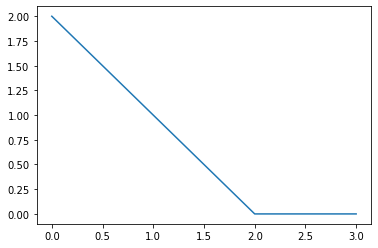

In [15]:
fraction_list_with_xy=[]
res_start = 0
res_end = 400
res_step = 100
res_list = np.arange(res_start,res_end,res_step)
no_of_false_events = Parallel(n_jobs=5)(delayed(get_surival_fraction_after_energy_para)(fv) for fv in res_list)
fraction_list_with_xy.append(no_of_false_events)
#print("This process has taken %d seconds" %(end-start))  
plt.plot(fraction_list_with_xy[0])
np.savetxt("Results_Paper/fvstudy_0_to_400mm_in_100_no_of_events_0vecec_new_12ers_10z_10xy_20191112.txt",fraction_list_with_xy)

In [31]:
def get_surival_fraction_after_energy_para(fv):
    fraction_list=[]
    no_of_false_events = 0
    for file in files:
        df_bkg = transform_root_file_and_sort_by_z(file)
        initial_events=len(np.unique(df_bkg["entry"]))
        print(initial_events, file)
        data_frame=df_bkg
        xy_res=10
        z_res=10
        decay="2vECB+"
        e_res1=30.98
        e_res2=12*0.37
        threshold_energy=250
        threshold=False
        permu=True
        df_temp = energy_criteria_selection(get_data_frame_with_summed_preselected_energy_xy_and_fv(data_frame,z_res,xy_res,decay,fv=fv,no_of_events=initial_events),decay,e_res1,e_res2,threshold_energy,threshold,permu)
        fraction = len(np.unique(df_temp.event_id))/initial_events*100
        no_of_false_events += len(np.unique(df_temp.event_id))
        print(no_of_false_events, "no of false events ", fv, "mm" )
        fraction_list.append(fraction)
    #return df_temp
    return no_of_false_events

/mnt/c/Linux/AC3/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


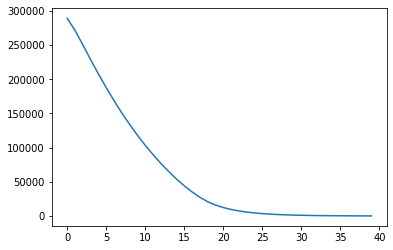

In [32]:
fraction_list_with_xy=[]
res_start = 0
res_end = 400
res_step = 10
res_list = np.arange(res_start,res_end,res_step)
no_of_false_events = Parallel(n_jobs=10)(delayed(get_surival_fraction_after_energy_para)(fv) for fv in res_list)
fraction_list_with_xy.append(no_of_false_events)
#print("This process has taken %d seconds" %(end-start))  
plt.plot(fraction_list_with_xy[0])
np.savetxt("Results_Paper/fvstudy_0_to_400mm_in_10_no_of_events_2vecb+_12ers_10z_10xy_20191104.txt",fraction_list_with_xy)

In [33]:
def get_surival_fraction_after_energy_para(fv):
    fraction_list=[]
    no_of_false_events = 0
    initial_events=len(np.unique(df_2vecb["entry"]))
    data_frame=df_2vecb
    xy_res=10
    z_res=10
    decay="2vECB+"
    e_res1=30.98
    e_res2=12*0.37
    threshold_energy=250
    threshold=False
    permu=True
    df_temp = energy_criteria_selection(get_data_frame_with_summed_preselected_energy_xy_and_fv(data_frame,z_res,xy_res,decay,fv=fv,no_of_events=initial_events),decay,e_res1,e_res2,threshold_energy,threshold,permu)
    fraction = len(np.unique(df_temp.event_id))/initial_events*100
    no_of_false_events += len(np.unique(df_temp.event_id))
    print(no_of_false_events, "no of false events", fv, )
    fraction_list.append(fraction)
    #return df_temp
    return no_of_false_events

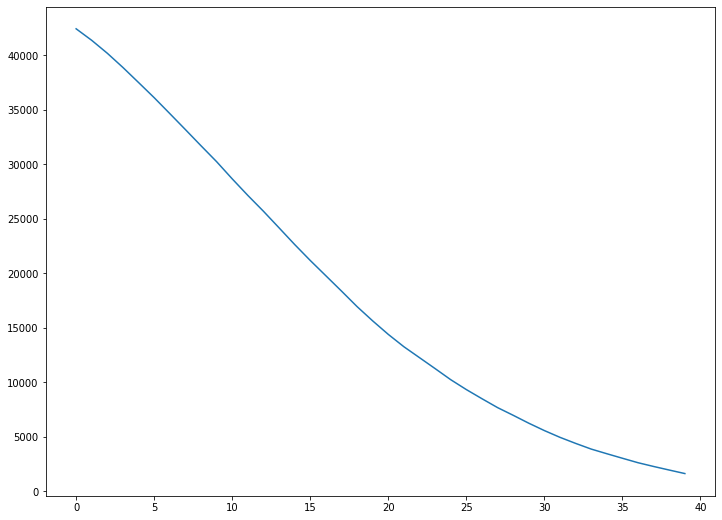

In [35]:
fraction_list_with_xy=[]
res_start = 0
res_end = 400
res_step = 10
res_list = np.arange(res_start,res_end,res_step)
no_of_false_events = Parallel(n_jobs=10)(delayed(get_surival_fraction_after_energy_para)(fv) for fv in res_list)
fraction_list_with_xy.append(no_of_false_events)
#print("This process has taken %d seconds" %(end-start))  
plt.plot(fraction_list_with_xy[0])


[3769.91118431 3707.07933124 3644.24747816 3581.41562509 3518.58377202
 3455.75191895 3392.92006588 3330.08821281 3267.25635973 3204.42450666
 3141.59265359 3078.76080052 3015.92894745 2953.09709437 2890.2652413
 2827.43338823 2764.60153516 2701.76968209 2638.93782902 2576.10597594
 2513.27412287 2450.4422698  2387.61041673 2324.77856366 2261.94671058
 2199.11485751 2136.28300444 2073.45115137 2010.6192983  1947.78744523
 1884.95559215 1822.12373908 1759.29188601 1696.46003294 1633.62817987
 1570.79632679 1507.96447372 1445.13262065 1382.30076758 1319.46891451]
[4523893.4211693  4374353.61085843 4227327.07467043 4082813.8126053
 3940813.82466304 3801327.11084365 3664353.67114713 3529893.50557349
 3397946.61412272 3268512.99679482 3141592.65358979 3017185.58450764
 2895291.78954835 2775911.26871194 2659044.0219984  2544690.04940773
 2432849.35093994 2323521.92659501 2216707.77637296 2112406.90027378
 2010619.29829747 1911344.97044403 1814583.91671346 1720336.13710577
 1628601.63162095 1

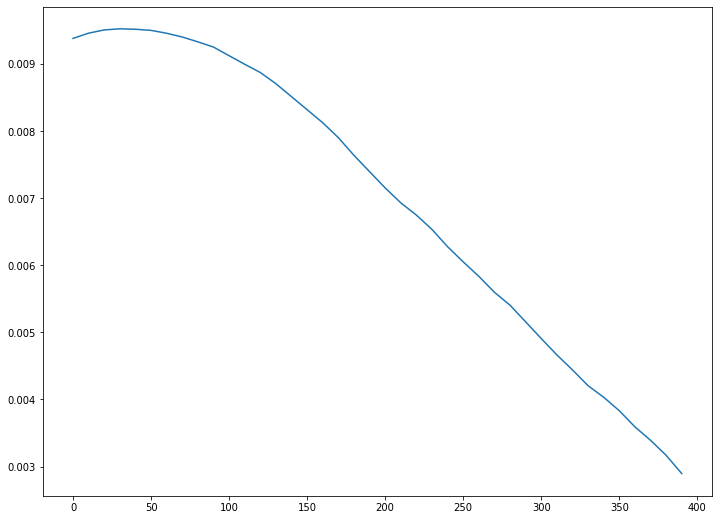

In [57]:
radius = np.sqrt((600-res_list)+(600-res_list))
surface = radius**2*np.pi
height = (1200-2*res_list)
volume = surface * height
print(surface)
print(volume)
plt.plot(res_list,np.divide(fraction_list_with_xy[0],volume))


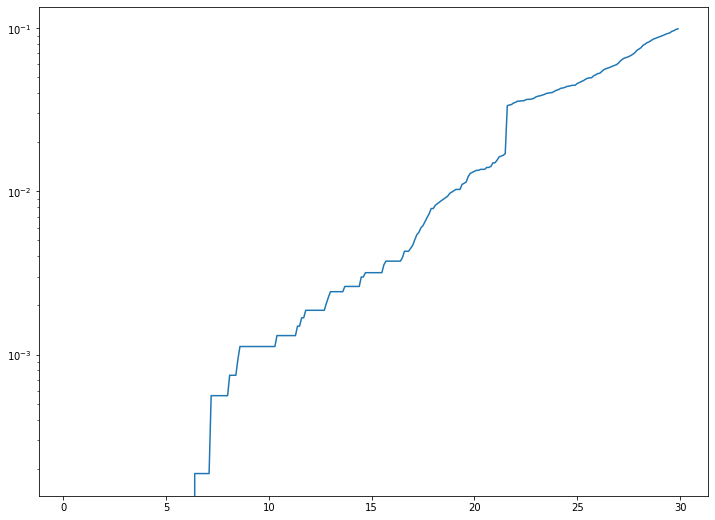

In [79]:
plt.plot(res_list,fraction_list_with_xy[0])
plt.yscale("log")

In [78]:
np.savetxt("Results_Paper/fraction_bkg_0.3_to_30_30z_10xy_e_res2_in0.1steps_0vecb+_2019_10_23.txt",fraction_list_with_xy)

### Check Threshold dependence in a nEXO detector ###

In [15]:
decay_frame_list = [df_2vecb,df_0vecb,df_0vECEC,df_0vbb_rc,,df_2vbb,df_0vECEC]
decay_list = ["2vECB+","0vECB+_new","0vECEC","0vB+B+_new","2vB+B+","0vECEC_2",]
num_cores=11


In [ ]:
for i in tqdm(np.arange(2,6,1)):
    print(len(np.unique(decay_frame_list[i].entry)))
    def get_surival_fraction_after_energy_para(threshold_energy):
        initial_events=10000#len(np.unique(decay_frame_list[i].entry))
        data_frame=decay_frame_list[i]
        z_res=10
        xy_res=10
        decay=decay_list[i]
        e_res1=30.98
        e_res2=12*0.37
        fv = 0
        threshold=True
        permu=True
        df_temp = energy_criteria_selection(get_data_frame_with_summed_preselected_energy_xy_and_fv(data_frame,z_res,xy_res,decay,fv,no_of_events=initial_events),decay,e_res1,e_res2,threshold_energy,threshold,permu)
        fraction = len(np.unique(df_temp.event_id))/initial_events*100
        #return df_temp
        return fraction
    start = time.time()
    fraction_list_with_xy = []
    res_start = 1
    res_end = 300
    res_step = 1
    res_list = np.arange(res_start,res_end,res_step)
    fraction_result = Parallel(n_jobs=num_cores)(delayed(get_surival_fraction_after_energy_para)(threshold_energy) for threshold_energy in res_list)
    fraction_list_with_xy.append(fraction_result)
    #print("This process has taken %d seconds" %(end-start))  
    plt.plot(fraction_list_with_xy[0])
    plt.show()
    np.savetxt("Results_Paper/fraction_5_to_300_threshold_in_1steps_10z_10xy_%s_1_2019_12_07.txt" %(decay_list[i]),fraction_list_with_xy)



  0%|          | 0/4 [00:00<?, ?it/s]

100000


/mnt/c/Linux/AC3/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


### Check dependence on resolution with nEXO ###





  0%|          | 0/3 [00:00<?, ?it/s]




  0%|          | 0/49 [00:00<?, ?it/s]

99998







  2%|▏         | 1/49 [00:01<01:33,  1.95s/it]




 45%|████▍     | 22/49 [06:52<03:15,  7.22s/it]




 47%|████▋     | 23/49 [06:53<02:26,  5.62s/it]




 49%|████▉     | 24/49 [07:03<02:51,  6.84s/it]




 51%|█████     | 25/49 [07:04<02:03,  5.16s/it]




 53%|█████▎    | 26/49 [07:05<01:26,  3.76s/it]




 55%|█████▌    | 27/49 [07:14<01:55,  5.27s/it]




 57%|█████▋    | 28/49 [07:16<01:33,  4.44s/it]




 59%|█████▉    | 29/49 [07:26<01:59,  5.96s/it]




 61%|██████    | 30/49 [07:43<02:56,  9.30s/it]




 63%|██████▎   | 31/49 [08:17<05:00, 16.67s/it]




 65%|██████▌   | 32/49 [09:53<11:29, 40.55s/it]




 67%|██████▋   | 33/49 [13:30<24:56, 93.54s/it]




 69%|██████▉   | 34/49 [13:31<16:26, 65.78s/it]




 71%|███████▏  | 35/49 [13:41<11:25, 48.97s/it]




 73%|███████▎  | 36/49 [13:43<07:33, 34.91s/it]




 76%|███████▌  | 37/49 [13:50<05:19, 26.63s/it]




 78%|███████▊  | 38/49 [13:57<03:46, 20.62s/it]




 80%|███████▉  | 39/49 [14:01<02:37, 15.78s/it]




 82%|███

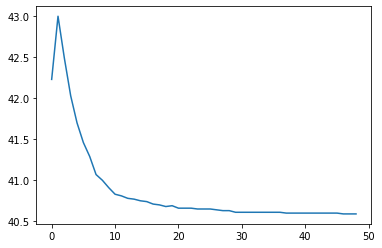





 33%|███▎      | 1/3 [31:00<1:02:01, 1860.51s/it]




  0%|          | 0/49 [00:00<?, ?it/s]

99998







 45%|████▍     | 22/49 [06:05<07:28, 16.62s/it]




 47%|████▋     | 23/49 [06:09<05:30, 12.71s/it]




 49%|████▉     | 24/49 [06:10<03:50,  9.21s/it]




 51%|█████     | 25/49 [06:10<02:35,  6.48s/it]




 53%|█████▎    | 26/49 [06:17<02:36,  6.83s/it]




 55%|█████▌    | 27/49 [06:19<01:58,  5.38s/it]




 57%|█████▋    | 28/49 [06:27<02:05,  5.97s/it]




 59%|█████▉    | 29/49 [06:39<02:33,  7.69s/it]




 61%|██████    | 30/49 [07:03<04:01, 12.73s/it]




 63%|██████▎   | 31/49 [07:21<04:18, 14.36s/it]




 65%|██████▌   | 32/49 [09:05<11:41, 41.25s/it]




 67%|██████▋   | 33/49 [12:20<23:19, 87.45s/it]




 69%|██████▉   | 34/49 [12:21<15:20, 61.39s/it]




 71%|███████▏  | 35/49 [12:29<10:34, 45.32s/it]




 73%|███████▎  | 36/49 [12:30<06:57, 32.12s/it]




 76%|███████▌  | 37/49 [12:33<04:41, 23.43s/it]




 78%|███████▊  | 38/49 [12:36<03:09, 17.25s/it]




 80%|███████▉  | 39/49 [12:46<02:30, 15.04s/it]




 82%|████████▏ | 40/49 [12:55<01:58, 13.22s/it]




 84%|██

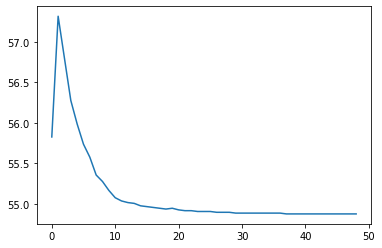





 67%|██████▋   | 2/3 [59:18<30:11, 1811.63s/it]  




  0%|          | 0/49 [00:00<?, ?it/s]

100000







 45%|████▍     | 22/49 [19:41<24:10, 53.71s/it]




 47%|████▋     | 23/49 [19:47<17:03, 39.35s/it]




 49%|████▉     | 24/49 [19:59<13:00, 31.23s/it]




 51%|█████     | 25/49 [20:00<08:53, 22.24s/it]




 53%|█████▎    | 26/49 [20:28<09:10, 23.92s/it]




 55%|█████▌    | 27/49 [21:16<11:25, 31.15s/it]




 57%|█████▋    | 28/49 [21:21<08:04, 23.08s/it]




 59%|█████▉    | 29/49 [21:37<07:02, 21.11s/it]




 61%|██████    | 30/49 [23:03<12:49, 40.49s/it]




 63%|██████▎   | 31/49 [25:06<19:36, 65.35s/it]




 65%|██████▌   | 32/49 [30:43<41:34, 146.74s/it]




 67%|██████▋   | 33/49 [39:18<1:08:37, 257.32s/it]




 69%|██████▉   | 34/49 [39:19<45:03, 180.26s/it]  




 71%|███████▏  | 35/49 [39:26<29:55, 128.26s/it]




 73%|███████▎  | 36/49 [39:34<20:01, 92.46s/it] 




 76%|███████▌  | 37/49 [40:06<14:50, 74.19s/it]




 78%|███████▊  | 38/49 [40:45<11:39, 63.59s/it]




 80%|███████▉  | 39/49 [41:03<08:20, 50.00s/it]




 82%|████████▏ | 40/49 [41:21<06:02, 40.26s/it]




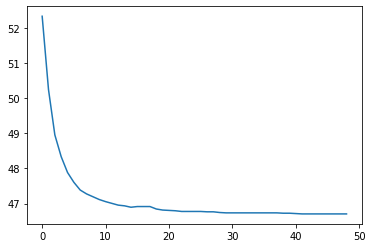





100%|██████████| 3/3 [2:30:20<00:00, 3006.78s/it]


In [24]:
for i in tqdm(np.arange(0,6,1)):
    print(len(np.unique(decay_frame_list[i].entry)))
    def get_surival_fraction_after_energy_para(z_res):
        initial_events=9999#len(np.unique(decay_frame_list[i].entry))
        data_frame=decay_frame_list[i]
        xy_res=3
        decay=decay_list[i]
        e_res1=30.98
        e_res2=12*0.37
        threshold_energy = 250
        threshold=False
        permu=True
        df_temp = energy_criteria_selection(get_data_frame_with_summed_preselected_energy_xy(data_frame,z_res,xy_res,decay,no_of_events=initial_events),decay,e_res1,e_res2,threshold_energy,threshold,permu)
        fraction = len(np.unique(df_temp.event_id))/initial_events*100
        #return df_temp
        return fraction
    start = time.time()
    fraction_list_with_xy = []
    res_start = 1
    res_end = 50
    res_step = 1
    res_list = np.arange(res_start,res_end,res_step)
    fraction_result = Parallel(n_jobs=num_cores)(delayed(get_surival_fraction_after_energy_para)(zres) for zres in tqdm(res_list))
    fraction_list_with_xy.append(fraction_result)
    #print("This process has taken %d seconds" %(end-start))  
    plt.plot(fraction_list_with_xy[0])
    plt.show()
    np.savetxt("Results_Paper/fraction_1_to_50_zres_in_1steps_3xy_nothreshold_%s_1_2019_11_10.txt" %(decay_list[i]),fraction_list_with_xy)



  0%|          | 0/6 [00:00<?, ?it/s]


  0%|          | 0/49 [00:00<?, ?it/s]

100000





  2%|▏         | 1/49 [00:01<01:20,  1.68s/it]


 41%|████      | 20/49 [01:23<01:11,  2.46s/it]


 43%|████▎     | 21/49 [01:23<00:55,  1.99s/it]


 45%|████▍     | 22/49 [01:24<00:41,  1.53s/it]


 47%|████▋     | 23/49 [01:25<00:36,  1.41s/it]


 49%|████▉     | 24/49 [01:26<00:32,  1.31s/it]


 51%|█████     | 25/49 [01:27<00:29,  1.25s/it]


 53%|█████▎    | 26/49 [01:30<00:37,  1.63s/it]


 55%|█████▌    | 27/49 [01:33<00:49,  2.24s/it]


 57%|█████▋    | 28/49 [01:38<01:00,  2.86s/it]


 59%|█████▉    | 29/49 [01:49<01:48,  5.44s/it]


 61%|██████    | 30/49 [02:40<06:00, 18.97s/it]


 63%|██████▎   | 31/49 [02:42<04:10, 13.91s/it]


 65%|██████▌   | 32/49 [02:42<02:48,  9.92s/it]


 67%|██████▋   | 33/49 [02:43<01:51,  6.98s/it]


 69%|██████▉   | 34/49 [02:44<01:19,  5.31s/it]


 71%|███████▏  | 35/49 [02:44<00:53,  3.81s/it]


 73%|███████▎  | 36/49 [02:47<00:44,  3.46s/it]


 76%|███████▌  | 37/49 [02:50<00:39,  3.27s/it]


 78%|███████▊  | 38/49 [02:54<00:40,  3.65s/it]


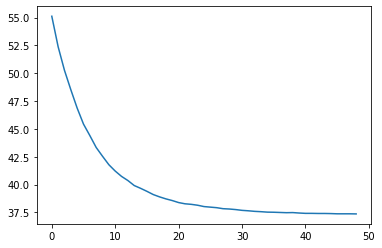



 17%|█▋        | 1/6 [06:36<33:04, 396.90s/it]


  0%|          | 0/49 [00:00<?, ?it/s]

100000





 41%|████      | 20/49 [01:08<01:39,  3.42s/it]


 43%|████▎     | 21/49 [01:08<01:11,  2.55s/it]


 45%|████▍     | 22/49 [01:09<00:54,  2.03s/it]


 47%|████▋     | 23/49 [01:10<00:41,  1.59s/it]


 49%|████▉     | 24/49 [01:10<00:31,  1.27s/it]


 51%|█████     | 25/49 [01:11<00:25,  1.06s/it]


 53%|█████▎    | 26/49 [01:13<00:33,  1.45s/it]


 55%|█████▌    | 27/49 [01:14<00:24,  1.12s/it]


 57%|█████▋    | 28/49 [01:17<00:36,  1.72s/it]


 59%|█████▉    | 29/49 [01:23<00:59,  2.97s/it]


 61%|██████    | 30/49 [02:18<05:55, 18.73s/it]


 63%|██████▎   | 31/49 [02:18<03:57, 13.21s/it]


 65%|██████▌   | 32/49 [02:19<02:38,  9.34s/it]


 67%|██████▋   | 33/49 [02:19<01:45,  6.62s/it]


 69%|██████▉   | 34/49 [02:19<01:10,  4.72s/it]


 71%|███████▏  | 35/49 [02:21<00:53,  3.86s/it]


 76%|███████▌  | 37/49 [02:22<00:33,  2.80s/it]


 78%|███████▊  | 38/49 [02:25<00:30,  2.79s/it]


 80%|███████▉  | 39/49 [02:31<00:38,  3.80s/it]


 82%|████████▏ | 40/49 [03:26<02:53, 19.32s/it]

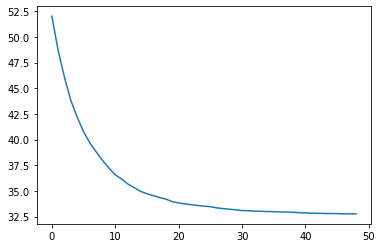



 33%|███▎      | 2/6 [12:19<25:22, 380.71s/it]


  0%|          | 0/49 [00:00<?, ?it/s]

100000





 41%|████      | 20/49 [03:27<05:01, 10.39s/it]


 43%|████▎     | 21/49 [03:30<03:46,  8.07s/it]


 45%|████▍     | 22/49 [03:37<03:32,  7.86s/it]


 47%|████▋     | 23/49 [03:53<04:23, 10.14s/it]


 49%|████▉     | 24/49 [04:00<03:52,  9.29s/it]


 51%|█████     | 25/49 [04:20<04:58, 12.43s/it]


 53%|█████▎    | 26/49 [04:58<07:41, 20.05s/it]


 55%|█████▌    | 27/49 [06:02<12:13, 33.36s/it]


 57%|█████▋    | 28/49 [06:46<12:47, 36.54s/it]


 59%|█████▉    | 29/49 [06:47<08:35, 25.78s/it]


 61%|██████    | 30/49 [06:51<06:04, 19.21s/it]


 63%|██████▎   | 31/49 [07:05<05:20, 17.78s/it]


 65%|██████▌   | 32/49 [07:06<03:39, 12.88s/it]


 67%|██████▋   | 33/49 [07:27<04:04, 15.27s/it]


 69%|██████▉   | 34/49 [07:54<04:39, 18.64s/it]


 71%|███████▏  | 35/49 [08:03<03:40, 15.76s/it]


 73%|███████▎  | 36/49 [09:06<06:31, 30.12s/it]


 76%|███████▌  | 37/49 [09:51<06:51, 34.31s/it]


 78%|███████▊  | 38/49 [09:52<04:27, 24.34s/it]


 80%|███████▉  | 39/49 [09:52<02:52, 17.23s/it]

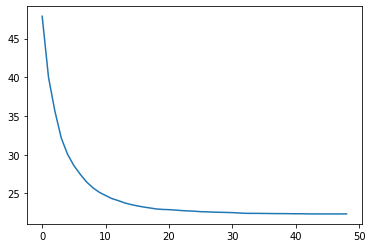



 50%|█████     | 3/6 [29:43<28:58, 579.55s/it]


  0%|          | 0/49 [00:00<?, ?it/s]

99998





 41%|████      | 20/49 [02:57<04:17,  8.89s/it]


 43%|████▎     | 21/49 [03:03<03:40,  7.88s/it]


 45%|████▍     | 22/49 [03:07<03:01,  6.73s/it]


 47%|████▋     | 23/49 [03:19<03:35,  8.29s/it]


 49%|████▉     | 24/49 [03:26<03:19,  7.97s/it]


 51%|█████     | 25/49 [03:40<03:56,  9.86s/it]


 53%|█████▎    | 26/49 [04:00<04:56, 12.90s/it]


 55%|█████▌    | 27/49 [04:36<07:11, 19.62s/it]


 57%|█████▋    | 28/49 [05:25<09:59, 28.54s/it]


 59%|█████▉    | 29/49 [05:57<09:51, 29.58s/it]


 61%|██████    | 30/49 [05:57<06:35, 20.80s/it]


 63%|██████▎   | 31/49 [05:59<04:33, 15.18s/it]


 65%|██████▌   | 32/49 [06:10<03:56, 13.93s/it]


 67%|██████▋   | 33/49 [06:17<03:08, 11.79s/it]


 69%|██████▉   | 34/49 [06:34<03:21, 13.41s/it]


 71%|███████▏  | 35/49 [06:50<03:17, 14.12s/it]


 73%|███████▎  | 36/49 [07:24<04:20, 20.05s/it]


 76%|███████▌  | 37/49 [07:31<03:13, 16.12s/it]


 78%|███████▊  | 38/49 [08:13<04:23, 23.91s/it]


 80%|███████▉  | 39/49 [08:42<04:14, 25.43s/it]

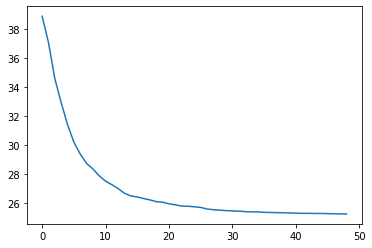



 67%|██████▋   | 4/6 [44:24<22:19, 669.89s/it]


  0%|          | 0/49 [00:00<?, ?it/s]

99998





 41%|████      | 20/49 [02:40<03:53,  8.05s/it]


 43%|████▎     | 21/49 [02:46<03:27,  7.40s/it]


 45%|████▍     | 22/49 [02:50<02:51,  6.34s/it]


 47%|████▋     | 23/49 [02:55<02:33,  5.91s/it]


 49%|████▉     | 24/49 [03:07<03:09,  7.60s/it]


 51%|█████     | 25/49 [03:16<03:15,  8.15s/it]


 53%|█████▎    | 26/49 [03:43<05:17, 13.82s/it]


 55%|█████▌    | 27/49 [04:05<05:56, 16.20s/it]


 57%|█████▋    | 28/49 [04:51<08:48, 25.15s/it]


 59%|█████▉    | 29/49 [05:15<08:18, 24.93s/it]


 61%|██████    | 30/49 [05:20<06:00, 18.98s/it]


 63%|██████▎   | 31/49 [05:22<04:08, 13.82s/it]


 65%|██████▌   | 32/49 [05:32<03:34, 12.64s/it]


 67%|██████▋   | 33/49 [05:40<02:57, 11.11s/it]


 69%|██████▉   | 34/49 [05:46<02:27,  9.81s/it]


 71%|███████▏  | 35/49 [06:12<03:22, 14.48s/it]


 73%|███████▎  | 36/49 [06:36<03:45, 17.32s/it]


 76%|███████▌  | 37/49 [06:42<02:47, 13.94s/it]


 78%|███████▊  | 38/49 [07:19<03:50, 20.94s/it]


 80%|███████▉  | 39/49 [07:40<03:29, 20.92s/it]

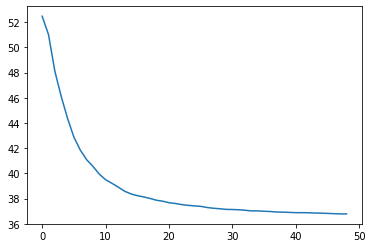



 83%|████████▎ | 5/6 [57:48<11:50, 710.24s/it]


  0%|          | 0/49 [00:00<?, ?it/s]

100000





 41%|████      | 20/49 [06:03<08:47, 18.17s/it]


 43%|████▎     | 21/49 [06:08<06:42, 14.38s/it]


 45%|████▍     | 22/49 [06:20<06:03, 13.45s/it]


 47%|████▋     | 23/49 [06:34<05:58, 13.78s/it]


 49%|████▉     | 24/49 [06:56<06:44, 16.19s/it]


 51%|█████     | 25/49 [07:39<09:40, 24.17s/it]


 53%|█████▎    | 26/49 [08:22<11:23, 29.71s/it]


 55%|█████▌    | 27/49 [10:20<20:38, 56.29s/it]


 57%|█████▋    | 28/49 [11:18<19:52, 56.80s/it]


 59%|█████▉    | 29/49 [11:19<13:23, 40.20s/it]


 61%|██████    | 30/49 [11:25<09:26, 29.80s/it]


 63%|██████▎   | 31/49 [11:35<07:11, 23.95s/it]


 65%|██████▌   | 32/49 [11:54<06:19, 22.30s/it]


 67%|██████▋   | 33/49 [12:31<07:09, 26.82s/it]


 69%|██████▉   | 34/49 [12:39<05:19, 21.31s/it]


 71%|███████▏  | 35/49 [13:21<06:22, 27.32s/it]


 73%|███████▎  | 36/49 [15:23<12:05, 55.84s/it]


 76%|███████▌  | 37/49 [16:15<10:55, 54.62s/it]


 78%|███████▊  | 38/49 [16:19<07:12, 39.32s/it]


 80%|███████▉  | 39/49 [16:24<04:52, 29.23s/it]

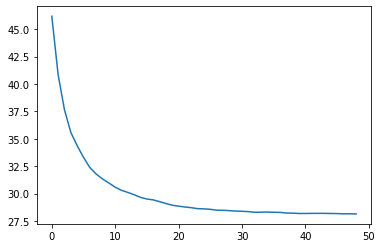



100%|██████████| 6/6 [1:26:29<00:00, 864.98s/it] 


In [18]:
for i in tqdm(np.arange(0,6,1)):
    print(len(np.unique(decay_frame_list[i].entry)))
    def get_surival_fraction_after_energy_para(z_res):
        initial_events=9999#len(np.unique(decay_frame_list[i].entry))
        data_frame=decay_frame_list[i]
        xy_res=10
        decay=decay_list[i]
        e_res1=30.98
        e_res2=12*0.37
        threshold_energy = 250
        threshold=False
        permu=True
        df_temp = energy_criteria_selection(get_data_frame_with_summed_preselected_energy_xy(data_frame,z_res,xy_res,decay,no_of_events=initial_events),decay,e_res1,e_res2,threshold_energy,threshold,permu)
        fraction = len(np.unique(df_temp.event_id))/initial_events*100
        #return df_temp
        return fraction
    start = time.time()
    fraction_list_with_xy = []
    res_start = 1
    res_end = 50
    res_step = 1
    res_list = np.arange(res_start,res_end,res_step)
    fraction_result = Parallel(n_jobs=num_cores)(delayed(get_surival_fraction_after_energy_para)(zres) for zres in tqdm(res_list))
    fraction_list_with_xy.append(fraction_result)
    #print("This process has taken %d seconds" %(end-start))  
    plt.plot(fraction_list_with_xy[0])
    plt.show()
    np.savetxt("Results_Paper/fraction_1_to_50_zres_in_1steps_10xy_nothreshold_%s_1_2019_11_10.txt" %(decay_list[i]),fraction_list_with_xy)





  0%|          | 0/6 [00:00<?, ?it/s]




  0%|          | 0/49 [00:00<?, ?it/s]

100000







  2%|▏         | 1/49 [00:00<00:41,  1.15it/s]




 45%|████▍     | 22/49 [01:09<00:42,  1.58s/it]




 47%|████▋     | 23/49 [01:09<00:30,  1.16s/it]




 49%|████▉     | 24/49 [01:11<00:33,  1.33s/it]




 51%|█████     | 25/49 [01:11<00:26,  1.11s/it]




 53%|█████▎    | 26/49 [01:12<00:22,  1.02it/s]




 55%|█████▌    | 27/49 [01:13<00:25,  1.17s/it]




 57%|█████▋    | 28/49 [01:15<00:29,  1.41s/it]




 59%|█████▉    | 29/49 [01:18<00:35,  1.79s/it]




 61%|██████    | 30/49 [01:22<00:46,  2.43s/it]




 63%|██████▎   | 31/49 [01:28<01:05,  3.62s/it]




 65%|██████▌   | 32/49 [01:42<01:51,  6.53s/it]




 67%|██████▋   | 33/49 [02:12<03:40, 13.79s/it]




 69%|██████▉   | 34/49 [02:14<02:30, 10.03s/it]




 71%|███████▏  | 35/49 [02:14<01:39,  7.13s/it]




 73%|███████▎  | 36/49 [02:14<01:06,  5.08s/it]




 76%|███████▌  | 37/49 [02:15<00:43,  3.62s/it]




 78%|███████▊  | 38/49 [02:16<00:33,  3.05s/it]




 80%|███████▉  | 39/49 [02:18<00:26,  2.66s/it]




 82%|███

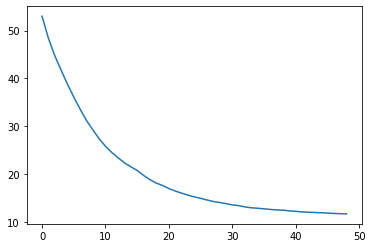





 17%|█▋        | 1/6 [04:52<24:20, 292.13s/it]




  0%|          | 0/49 [00:00<?, ?it/s]

100000







 45%|████▍     | 22/49 [00:57<01:10,  2.62s/it]




 47%|████▋     | 23/49 [00:57<00:49,  1.90s/it]




 49%|████▉     | 24/49 [00:58<00:38,  1.56s/it]




 51%|█████     | 25/49 [00:59<00:33,  1.41s/it]




 55%|█████▌    | 27/49 [01:01<00:27,  1.27s/it]




 57%|█████▋    | 28/49 [01:03<00:30,  1.45s/it]




 59%|█████▉    | 29/49 [01:04<00:24,  1.21s/it]




 61%|██████    | 30/49 [01:07<00:35,  1.88s/it]




 63%|██████▎   | 31/49 [01:10<00:37,  2.06s/it]




 65%|██████▌   | 32/49 [01:18<01:07,  3.96s/it]




 67%|██████▋   | 33/49 [01:51<03:23, 12.69s/it]




 71%|███████▏  | 35/49 [01:51<02:04,  8.90s/it]




 73%|███████▎  | 36/49 [01:52<01:24,  6.51s/it]




 76%|███████▌  | 37/49 [01:52<00:55,  4.63s/it]




 78%|███████▊  | 38/49 [01:54<00:40,  3.65s/it]




 80%|███████▉  | 39/49 [01:54<00:26,  2.66s/it]




 82%|████████▏ | 40/49 [01:55<00:18,  2.09s/it]




 84%|████████▎ | 41/49 [01:59<00:21,  2.68s/it]




 86%|████████▌ | 42/49 [02:01<00:17,  2.47s/it]




 88%|██

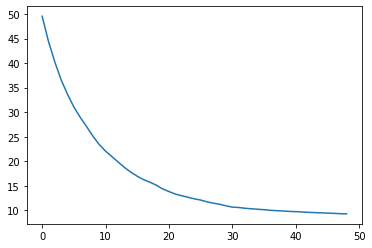





 33%|███▎      | 2/6 [08:54<18:28, 277.17s/it]




  0%|          | 0/49 [00:00<?, ?it/s]

100000







 45%|████▍     | 22/49 [01:33<01:55,  4.27s/it]




 47%|████▋     | 23/49 [01:37<01:43,  3.98s/it]




 49%|████▉     | 24/49 [01:38<01:21,  3.25s/it]




 51%|█████     | 25/49 [01:43<01:28,  3.70s/it]




 53%|█████▎    | 26/49 [01:46<01:21,  3.56s/it]




 55%|█████▌    | 27/49 [01:58<02:09,  5.87s/it]




 57%|█████▋    | 28/49 [02:06<02:19,  6.66s/it]




 59%|█████▉    | 29/49 [02:34<04:20, 13.05s/it]




 61%|██████    | 30/49 [03:05<05:49, 18.38s/it]




 63%|██████▎   | 31/49 [03:07<04:03, 13.53s/it]




 65%|██████▌   | 32/49 [03:08<02:43,  9.62s/it]




 67%|██████▋   | 33/49 [03:11<02:04,  7.77s/it]




 69%|██████▉   | 34/49 [03:12<01:25,  5.67s/it]




 71%|███████▏  | 35/49 [03:13<00:59,  4.25s/it]




 73%|███████▎  | 36/49 [03:25<01:27,  6.75s/it]




 76%|███████▌  | 37/49 [03:30<01:13,  6.14s/it]




 78%|███████▊  | 38/49 [04:02<02:32, 13.86s/it]




 80%|███████▉  | 39/49 [04:32<03:06, 18.62s/it]




 82%|████████▏ | 40/49 [04:32<01:57, 13.09s/it]




 84%|██

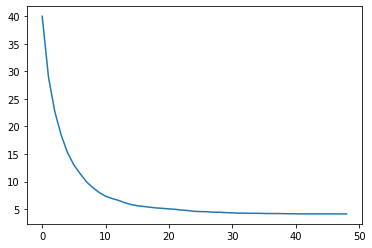





 50%|█████     | 3/6 [17:08<17:06, 342.16s/it]




  0%|          | 0/49 [00:00<?, ?it/s]

99998







 45%|████▍     | 22/49 [01:25<01:44,  3.86s/it]




 47%|████▋     | 23/49 [01:27<01:28,  3.41s/it]




 49%|████▉     | 24/49 [01:33<01:43,  4.13s/it]




 51%|█████     | 25/49 [01:38<01:49,  4.57s/it]




 53%|█████▎    | 26/49 [01:40<01:27,  3.81s/it]




 55%|█████▌    | 27/49 [01:49<01:57,  5.34s/it]




 57%|█████▋    | 28/49 [01:58<02:13,  6.36s/it]




 59%|█████▉    | 29/49 [02:14<03:04,  9.24s/it]




 61%|██████    | 30/49 [02:40<04:29, 14.21s/it]




 63%|██████▎   | 31/49 [02:44<03:21, 11.19s/it]




 65%|██████▌   | 32/49 [02:47<02:27,  8.68s/it]




 67%|██████▋   | 33/49 [02:51<01:56,  7.29s/it]




 69%|██████▉   | 34/49 [02:55<01:35,  6.33s/it]




 71%|███████▏  | 35/49 [02:55<01:04,  4.62s/it]




 73%|███████▎  | 36/49 [03:05<01:19,  6.11s/it]




 76%|███████▌  | 37/49 [03:12<01:17,  6.42s/it]




 78%|███████▊  | 38/49 [03:28<01:40,  9.15s/it]




 80%|███████▉  | 39/49 [03:31<01:13,  7.36s/it]




 82%|████████▏ | 40/49 [03:54<01:47, 11.95s/it]




 84%|██

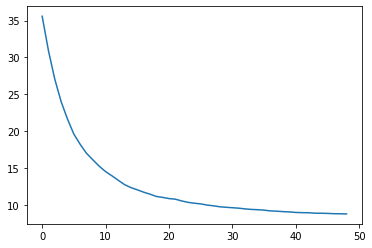





 67%|██████▋   | 4/6 [23:48<11:59, 359.67s/it]




  0%|          | 0/49 [00:00<?, ?it/s]

99998







 45%|████▍     | 22/49 [01:19<01:37,  3.62s/it]




 47%|████▋     | 23/49 [01:22<01:25,  3.28s/it]




 49%|████▉     | 24/49 [01:24<01:14,  2.96s/it]




 51%|█████     | 25/49 [01:29<01:27,  3.63s/it]




 53%|█████▎    | 26/49 [01:34<01:32,  4.02s/it]




 55%|█████▌    | 27/49 [01:40<01:38,  4.46s/it]




 57%|█████▋    | 28/49 [01:51<02:16,  6.49s/it]




 59%|█████▉    | 29/49 [02:08<03:15,  9.76s/it]




 61%|██████    | 30/49 [02:27<03:54, 12.35s/it]




 63%|██████▎   | 31/49 [02:37<03:33, 11.86s/it]




 65%|██████▌   | 32/49 [02:39<02:31,  8.90s/it]




 67%|██████▋   | 33/49 [02:39<01:40,  6.29s/it]




 69%|██████▉   | 34/49 [02:44<01:28,  5.90s/it]




 71%|███████▏  | 35/49 [02:50<01:21,  5.85s/it]




 73%|███████▎  | 36/49 [02:53<01:03,  4.85s/it]




 76%|███████▌  | 37/49 [03:05<01:25,  7.09s/it]




 78%|███████▊  | 38/49 [03:17<01:33,  8.53s/it]




 80%|███████▉  | 39/49 [03:22<01:14,  7.46s/it]




 82%|████████▏ | 40/49 [03:37<01:29,  9.90s/it]




 84%|██

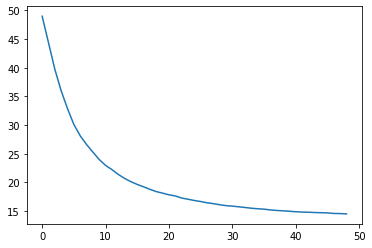





 83%|████████▎ | 5/6 [30:10<06:06, 366.45s/it]




  0%|          | 0/49 [00:00<?, ?it/s]

100000







 45%|████▍     | 22/49 [02:06<02:35,  5.77s/it]




 47%|████▋     | 23/49 [02:11<02:22,  5.48s/it]




 49%|████▉     | 24/49 [02:16<02:08,  5.14s/it]




 51%|█████     | 25/49 [02:26<02:38,  6.58s/it]




 53%|█████▎    | 26/49 [02:34<02:42,  7.08s/it]




 55%|█████▌    | 27/49 [02:49<03:32,  9.65s/it]




 57%|█████▋    | 28/49 [03:14<04:54, 14.01s/it]




 59%|█████▉    | 29/49 [03:52<07:08, 21.40s/it]




 61%|██████    | 30/49 [04:11<06:30, 20.57s/it]




 63%|██████▎   | 31/49 [04:16<04:45, 15.85s/it]




 65%|██████▌   | 32/49 [04:17<03:12, 11.31s/it]




 67%|██████▋   | 33/49 [04:28<02:59, 11.23s/it]




 69%|██████▉   | 34/49 [04:32<02:16,  9.08s/it]




 71%|███████▏  | 35/49 [04:47<02:33, 10.94s/it]




 73%|███████▎  | 36/49 [05:08<03:02, 14.04s/it]




 76%|███████▌  | 37/49 [05:10<02:05, 10.44s/it]




 78%|███████▊  | 38/49 [05:45<03:15, 17.74s/it]




 80%|███████▉  | 39/49 [06:02<02:56, 17.64s/it]




 82%|████████▏ | 40/49 [06:07<02:04, 13.83s/it]




 84%|██

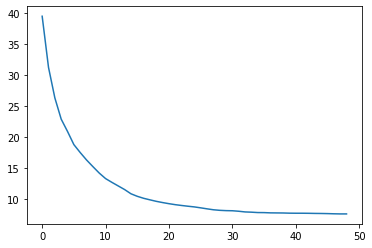





100%|██████████| 6/6 [42:30<00:00, 425.08s/it]


In [25]:
for i in tqdm(np.arange(0,6,1)):
    print(len(np.unique(decay_frame_list[i].entry)))
    def get_surival_fraction_after_energy_para(z_res):
        initial_events=9999#len(np.unique(decay_frame_list[i].entry))
        data_frame=decay_frame_list[i]
        xy_res=30
        decay=decay_list[i]
        e_res1=30.98
        e_res2=12*0.37
        threshold_energy = 250
        threshold=False
        permu=True
        df_temp = energy_criteria_selection(get_data_frame_with_summed_preselected_energy_xy(data_frame,z_res,xy_res,decay,no_of_events=initial_events),decay,e_res1,e_res2,threshold_energy,threshold,permu)
        fraction = len(np.unique(df_temp.event_id))/initial_events*100
        #return df_temp
        return fraction
    start = time.time()
    fraction_list_with_xy = []
    res_start = 1
    res_end = 50
    res_step = 1
    res_list = np.arange(res_start,res_end,res_step)
    fraction_result = Parallel(n_jobs=num_cores)(delayed(get_surival_fraction_after_energy_para)(zres) for zres in tqdm(res_list))
    fraction_list_with_xy.append(fraction_result)
    #print("This process has taken %d seconds" %(end-start))  
    plt.plot(fraction_list_with_xy[0])
    plt.show()
    np.savetxt("Results_Paper/fraction_1_to_50_zres_in_1steps_30xy_nothreshold_%s_1_2019_11_10.txt" %(decay_list[i]),fraction_list_with_xy)





  0%|          | 0/6 [00:00<?, ?it/s]




  0%|          | 0/49 [00:00<?, ?it/s]

100000







 45%|████▍     | 22/49 [01:00<01:14,  2.77s/it]




 47%|████▋     | 23/49 [01:01<00:52,  2.03s/it]




 49%|████▉     | 24/49 [01:02<00:46,  1.87s/it]




 51%|█████     | 25/49 [01:04<00:46,  1.96s/it]




 53%|█████▎    | 26/49 [01:07<00:50,  2.20s/it]




 55%|█████▌    | 27/49 [01:09<00:45,  2.06s/it]




 57%|█████▋    | 28/49 [01:12<00:47,  2.25s/it]




 59%|█████▉    | 29/49 [01:15<00:54,  2.70s/it]




 61%|██████    | 30/49 [01:19<00:54,  2.89s/it]




 63%|██████▎   | 31/49 [01:27<01:18,  4.37s/it]




 65%|██████▌   | 32/49 [01:40<02:01,  7.15s/it]




 67%|██████▋   | 33/49 [01:59<02:50, 10.63s/it]




 69%|██████▉   | 34/49 [01:59<01:52,  7.52s/it]




 71%|███████▏  | 35/49 [02:00<01:15,  5.37s/it]




 73%|███████▎  | 36/49 [02:01<00:55,  4.31s/it]




 76%|███████▌  | 37/49 [02:04<00:45,  3.76s/it]




 78%|███████▊  | 38/49 [02:05<00:32,  2.99s/it]




 80%|███████▉  | 39/49 [02:07<00:27,  2.76s/it]




 82%|████████▏ | 40/49 [02:11<00:27,  3.03s/it]




 84%|██

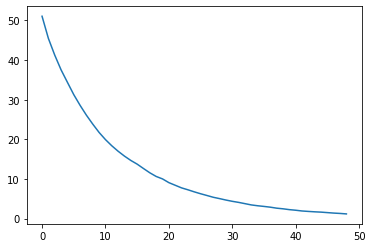





 17%|█▋        | 1/6 [04:19<21:36, 259.32s/it]




  0%|          | 0/49 [00:00<?, ?it/s]

100000







 45%|████▍     | 22/49 [00:54<01:06,  2.46s/it]




 49%|████▉     | 24/49 [00:55<00:47,  1.89s/it]




 51%|█████     | 25/49 [00:55<00:36,  1.52s/it]




 53%|█████▎    | 26/49 [00:56<00:27,  1.20s/it]




 55%|█████▌    | 27/49 [00:58<00:31,  1.43s/it]




 57%|█████▋    | 28/49 [01:00<00:35,  1.67s/it]




 59%|█████▉    | 29/49 [01:01<00:30,  1.50s/it]




 61%|██████    | 30/49 [01:03<00:30,  1.60s/it]




 63%|██████▎   | 31/49 [01:07<00:44,  2.46s/it]




 65%|██████▌   | 32/49 [01:14<01:03,  3.76s/it]




 67%|██████▋   | 33/49 [01:47<03:21, 12.61s/it]




 69%|██████▉   | 34/49 [01:48<02:13,  8.92s/it]




 71%|███████▏  | 35/49 [01:48<01:28,  6.29s/it]




 76%|███████▌  | 37/49 [01:49<00:54,  4.54s/it]




 78%|███████▊  | 38/49 [01:51<00:41,  3.78s/it]




 80%|███████▉  | 39/49 [01:54<00:34,  3.45s/it]




 82%|████████▏ | 40/49 [01:54<00:22,  2.52s/it]




 84%|████████▎ | 41/49 [01:55<00:17,  2.17s/it]




 86%|████████▌ | 42/49 [02:00<00:20,  2.99s/it]




 88%|██

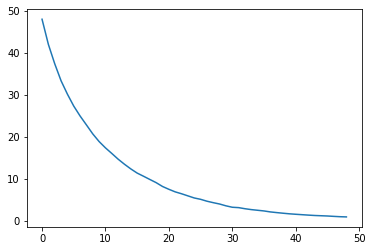





 33%|███▎      | 2/6 [08:13<16:46, 251.74s/it]




  0%|          | 0/49 [00:00<?, ?it/s]

100000







 45%|████▍     | 22/49 [01:20<01:38,  3.64s/it]




 47%|████▋     | 23/49 [01:20<01:09,  2.68s/it]




 49%|████▉     | 24/49 [01:22<00:58,  2.34s/it]




 51%|█████     | 25/49 [01:22<00:45,  1.89s/it]




 53%|█████▎    | 26/49 [01:24<00:42,  1.86s/it]




 55%|█████▌    | 27/49 [01:31<01:12,  3.31s/it]




 57%|█████▋    | 28/49 [01:37<01:27,  4.15s/it]




 59%|█████▉    | 29/49 [01:50<02:17,  6.88s/it]




 61%|██████    | 30/49 [02:13<03:38, 11.52s/it]




 63%|██████▎   | 31/49 [02:38<04:40, 15.58s/it]




 65%|██████▌   | 32/49 [02:38<03:08, 11.08s/it]




 67%|██████▋   | 33/49 [02:39<02:08,  8.02s/it]




 69%|██████▉   | 34/49 [02:39<01:25,  5.69s/it]




 71%|███████▏  | 35/49 [02:40<00:59,  4.26s/it]




 73%|███████▎  | 36/49 [02:49<01:12,  5.56s/it]




 76%|███████▌  | 37/49 [02:55<01:07,  5.63s/it]




 78%|███████▊  | 38/49 [03:07<01:23,  7.63s/it]




 80%|███████▉  | 39/49 [03:08<00:56,  5.68s/it]




 82%|████████▏ | 40/49 [03:30<01:35, 10.67s/it]




 84%|██

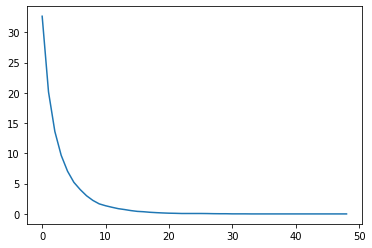





 50%|█████     | 3/6 [15:07<15:01, 300.40s/it]




  0%|          | 0/49 [00:00<?, ?it/s]

99998







 45%|████▍     | 22/49 [01:03<01:17,  2.87s/it]




 47%|████▋     | 23/49 [01:05<01:06,  2.55s/it]




 49%|████▉     | 24/49 [01:05<00:46,  1.88s/it]




 51%|█████     | 25/49 [01:08<00:51,  2.14s/it]




 53%|█████▎    | 26/49 [01:10<00:53,  2.33s/it]




 55%|█████▌    | 27/49 [01:14<00:57,  2.63s/it]




 57%|█████▋    | 28/49 [01:19<01:13,  3.51s/it]




 59%|█████▉    | 29/49 [01:28<01:43,  5.16s/it]




 61%|██████    | 30/49 [01:49<03:05,  9.76s/it]




 63%|██████▎   | 31/49 [02:05<03:30, 11.68s/it]




 65%|██████▌   | 32/49 [02:05<02:19,  8.22s/it]




 67%|██████▋   | 33/49 [02:07<01:40,  6.26s/it]




 69%|██████▉   | 34/49 [02:08<01:10,  4.73s/it]




 71%|███████▏  | 35/49 [02:10<00:55,  3.96s/it]




 73%|███████▎  | 36/49 [02:13<00:48,  3.72s/it]




 76%|███████▌  | 37/49 [02:18<00:49,  4.15s/it]




 78%|███████▊  | 38/49 [02:26<00:56,  5.13s/it]




 80%|███████▉  | 39/49 [02:28<00:42,  4.28s/it]




 82%|████████▏ | 40/49 [02:47<01:16,  8.55s/it]




 84%|██

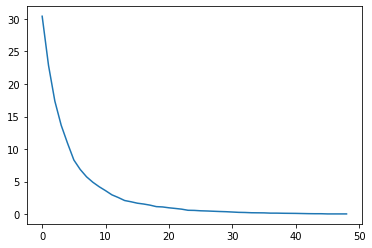





 67%|██████▋   | 4/6 [20:02<09:57, 298.98s/it]




  0%|          | 0/49 [00:00<?, ?it/s]

99998







 45%|████▍     | 22/49 [00:59<01:12,  2.70s/it]




 47%|████▋     | 23/49 [00:59<00:51,  1.97s/it]




 49%|████▉     | 24/49 [01:01<00:49,  2.00s/it]




 51%|█████     | 25/49 [01:04<00:49,  2.06s/it]




 53%|█████▎    | 26/49 [01:06<00:51,  2.23s/it]




 55%|█████▌    | 27/49 [01:09<00:55,  2.54s/it]




 57%|█████▋    | 28/49 [01:14<01:07,  3.21s/it]




 59%|█████▉    | 29/49 [01:23<01:37,  4.85s/it]




 61%|██████    | 30/49 [01:40<02:41,  8.48s/it]




 63%|██████▎   | 31/49 [01:56<03:12, 10.71s/it]




 65%|██████▌   | 32/49 [01:57<02:14,  7.91s/it]




 67%|██████▋   | 33/49 [01:59<01:36,  6.03s/it]




 69%|██████▉   | 34/49 [02:00<01:08,  4.59s/it]




 71%|███████▏  | 35/49 [02:03<00:59,  4.22s/it]




 73%|███████▎  | 36/49 [02:06<00:50,  3.87s/it]




 76%|███████▌  | 37/49 [02:11<00:47,  3.99s/it]




 78%|███████▊  | 38/49 [02:17<00:52,  4.75s/it]




 80%|███████▉  | 39/49 [02:19<00:38,  3.89s/it]




 82%|████████▏ | 40/49 [02:35<01:08,  7.62s/it]




 84%|██

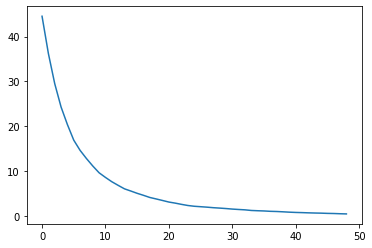





 83%|████████▎ | 5/6 [24:49<04:55, 295.17s/it]




  0%|          | 0/49 [00:00<?, ?it/s]

100000







 45%|████▍     | 22/49 [01:26<01:46,  3.94s/it]




 47%|████▋     | 23/49 [01:28<01:29,  3.45s/it]




 49%|████▉     | 24/49 [01:32<01:24,  3.40s/it]




 51%|█████     | 25/49 [01:35<01:21,  3.39s/it]




 53%|█████▎    | 26/49 [01:39<01:21,  3.55s/it]




 55%|█████▌    | 27/49 [01:43<01:18,  3.57s/it]




 57%|█████▋    | 28/49 [01:53<01:58,  5.64s/it]




 59%|█████▉    | 29/49 [02:10<02:59,  8.96s/it]




 61%|██████    | 30/49 [02:49<05:43, 18.06s/it]




 63%|██████▎   | 31/49 [02:50<03:54, 13.01s/it]




 65%|██████▌   | 32/49 [02:52<02:44,  9.68s/it]




 67%|██████▋   | 33/49 [02:54<01:58,  7.43s/it]




 69%|██████▉   | 34/49 [02:56<01:24,  5.66s/it]




 71%|███████▏  | 35/49 [02:58<01:05,  4.70s/it]




 73%|███████▎  | 36/49 [03:01<00:51,  3.95s/it]




 76%|███████▌  | 37/49 [03:10<01:06,  5.55s/it]




 78%|███████▊  | 38/49 [03:24<01:29,  8.15s/it]




 80%|███████▉  | 39/49 [04:04<02:57, 17.74s/it]




 82%|████████▏ | 40/49 [04:05<01:53, 12.65s/it]




 84%|██

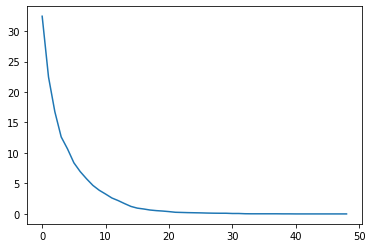





100%|██████████| 6/6 [33:04<00:00, 330.71s/it]


In [26]:
for i in tqdm(np.arange(0,6,1)):
    print(len(np.unique(decay_frame_list[i].entry)))
    def get_surival_fraction_after_energy_para(z_res):
        initial_events=9999#len(np.unique(decay_frame_list[i].entry))
        data_frame=decay_frame_list[i]
        xy_res=50000
        decay=decay_list[i]
        e_res1=30.98
        e_res2=12*0.37
        threshold_energy = 250
        threshold=False
        permu=True
        df_temp = energy_criteria_selection(get_data_frame_with_summed_preselected_energy_xy(data_frame,z_res,xy_res,decay,no_of_events=initial_events),decay,e_res1,e_res2,threshold_energy,threshold,permu)
        fraction = len(np.unique(df_temp.event_id))/initial_events*100
        #return df_temp
        return fraction
    start = time.time()
    fraction_list_with_xy = []
    res_start = 1
    res_end = 50
    res_step = 1
    res_list = np.arange(res_start,res_end,res_step)
    fraction_result = Parallel(n_jobs=num_cores)(delayed(get_surival_fraction_after_energy_para)(zres) for zres in tqdm(res_list))
    fraction_list_with_xy.append(fraction_result)
    #print("This process has taken %d seconds" %(end-start))  
    plt.plot(fraction_list_with_xy[0])
    plt.show()
    np.savetxt("Results_Paper/fraction_1_to_50_zres_in_1steps_noxy_nothreshold_%s_1_2019_11_10.txt" %(decay_list[i]),fraction_list_with_xy)

### Now DARWIN ###

In [27]:
decay_frame_list = [df_2vecb_d,df_0vecb_d,df_0vbb_rc_d,df_0vECEC_d,df_0vECEC_d,df_2vbb_d]
decay_list = ["2vECB+","0vECB+_new","0vB+B+_new","0vECEC","0vECEC_2","2vB+B+"]
num_cores=10





  0%|          | 0/6 [00:00<?, ?it/s]




  0%|          | 0/49 [00:00<?, ?it/s]

100000







 41%|████      | 20/49 [01:45<02:32,  5.26s/it]




 43%|████▎     | 21/49 [01:45<01:48,  3.86s/it]




 45%|████▍     | 22/49 [01:46<01:16,  2.83s/it]




 47%|████▋     | 23/49 [01:46<00:52,  2.03s/it]




 49%|████▉     | 24/49 [01:47<00:46,  1.84s/it]




 51%|█████     | 25/49 [01:50<00:46,  1.92s/it]




 53%|█████▎    | 26/49 [01:50<00:34,  1.50s/it]




 55%|█████▌    | 27/49 [01:53<00:44,  2.01s/it]




 57%|█████▋    | 28/49 [01:55<00:38,  1.84s/it]




 59%|█████▉    | 29/49 [02:10<02:00,  6.04s/it]




 61%|██████    | 30/49 [03:38<09:39, 30.49s/it]




 63%|██████▎   | 31/49 [03:40<06:32, 21.80s/it]




 65%|██████▌   | 32/49 [03:40<04:23, 15.47s/it]




 67%|██████▋   | 33/49 [03:41<02:57, 11.08s/it]




 69%|██████▉   | 34/49 [03:41<01:56,  7.79s/it]




 71%|███████▏  | 35/49 [03:44<01:26,  6.19s/it]




 73%|███████▎  | 36/49 [03:45<01:00,  4.64s/it]




 76%|███████▌  | 37/49 [03:46<00:45,  3.76s/it]




 78%|███████▊  | 38/49 [03:47<00:29,  2.68s/it]




 80%|██

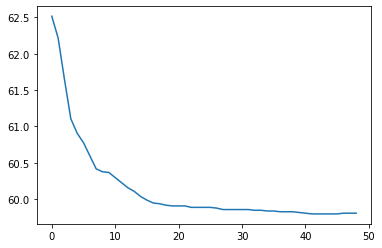





 17%|█▋        | 1/6 [08:57<44:48, 537.70s/it]




  0%|          | 0/49 [00:00<?, ?it/s]

100000







 41%|████      | 20/49 [01:16<01:51,  3.84s/it]




 43%|████▎     | 21/49 [01:16<01:17,  2.76s/it]




 45%|████▍     | 22/49 [01:17<00:54,  2.01s/it]




 47%|████▋     | 23/49 [01:17<00:41,  1.60s/it]




 51%|█████     | 25/49 [01:18<00:27,  1.15s/it]




 55%|█████▌    | 27/49 [01:18<00:20,  1.06it/s]




 57%|█████▋    | 28/49 [01:19<00:14,  1.43it/s]




 59%|█████▉    | 29/49 [01:26<00:52,  2.62s/it]




 61%|██████    | 30/49 [02:31<06:44, 21.30s/it]




 63%|██████▎   | 31/49 [02:32<04:35, 15.30s/it]




 65%|██████▌   | 32/49 [02:33<03:06, 10.99s/it]




 67%|██████▋   | 33/49 [02:33<02:04,  7.76s/it]




 69%|██████▉   | 34/49 [02:33<01:23,  5.54s/it]




 71%|███████▏  | 35/49 [02:34<00:55,  3.98s/it]




 76%|███████▌  | 37/49 [02:35<00:35,  2.93s/it]




 78%|███████▊  | 38/49 [02:36<00:26,  2.44s/it]




 80%|███████▉  | 39/49 [02:42<00:34,  3.42s/it]




 82%|████████▏ | 40/49 [03:46<03:15, 21.71s/it]




 84%|████████▎ | 41/49 [03:46<02:02, 15.29s/it]




 86%|██

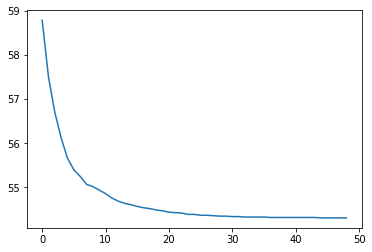





 33%|███▎      | 2/6 [15:15<32:38, 489.71s/it]




  0%|          | 0/49 [00:00<?, ?it/s]

100000







 41%|████      | 20/49 [11:44<17:02, 35.24s/it]




 43%|████▎     | 21/49 [11:47<11:51, 25.42s/it]




 45%|████▍     | 22/49 [11:47<08:02, 17.88s/it]




 47%|████▋     | 23/49 [11:55<06:27, 14.92s/it]




 49%|████▉     | 24/49 [12:09<06:01, 14.45s/it]




 51%|█████     | 25/49 [12:22<05:41, 14.22s/it]




 53%|█████▎    | 26/49 [12:26<04:14, 11.04s/it]




 55%|█████▌    | 27/49 [13:16<08:20, 22.76s/it]




 57%|█████▋    | 28/49 [14:51<15:31, 44.36s/it]




 59%|█████▉    | 29/49 [19:09<36:10, 108.53s/it]




 61%|██████    | 30/49 [23:22<48:06, 151.91s/it]




 63%|██████▎   | 31/49 [23:24<32:04, 106.93s/it]




 65%|██████▌   | 32/49 [23:24<21:13, 74.89s/it] 




 67%|██████▋   | 33/49 [23:25<14:01, 52.61s/it]




 69%|██████▉   | 34/49 [23:42<10:31, 42.08s/it]




 71%|███████▏  | 35/49 [23:43<06:56, 29.75s/it]




 73%|███████▎  | 36/49 [23:59<05:30, 25.42s/it]




 76%|███████▌  | 37/49 [24:39<05:58, 29.88s/it]




 78%|███████▊  | 38/49 [26:08<08:42, 47.49s/it]




 80

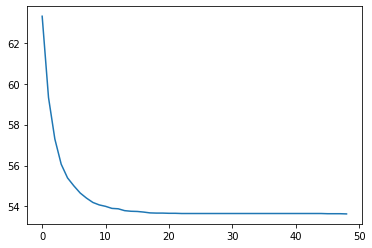





 50%|█████     | 3/6 [1:13:28<1:09:31, 1390.65s/it]




  0%|          | 0/49 [00:00<?, ?it/s]

100000







 41%|████      | 20/49 [07:08<10:22, 21.45s/it]




 43%|████▎     | 21/49 [07:16<08:02, 17.24s/it]




 45%|████▍     | 22/49 [07:16<05:26, 12.10s/it]




 47%|████▋     | 23/49 [07:26<05:00, 11.54s/it]




 49%|████▉     | 24/49 [07:31<03:59,  9.58s/it]




 51%|█████     | 25/49 [07:34<03:01,  7.54s/it]




 53%|█████▎    | 26/49 [07:47<03:28,  9.05s/it]




 55%|█████▌    | 27/49 [08:08<04:38, 12.65s/it]




 57%|█████▋    | 28/49 [08:37<06:08, 17.56s/it]




 59%|█████▉    | 29/49 [10:02<12:37, 37.88s/it]




 61%|██████    | 30/49 [14:29<33:48, 106.75s/it]




 63%|██████▎   | 31/49 [14:37<23:03, 76.88s/it] 




 65%|██████▌   | 32/49 [14:39<15:29, 54.67s/it]




 67%|██████▋   | 33/49 [14:53<11:19, 42.47s/it]




 69%|██████▉   | 34/49 [14:57<07:41, 30.76s/it]




 71%|███████▏  | 35/49 [14:59<05:12, 22.29s/it]




 73%|███████▎  | 36/49 [15:06<03:50, 17.71s/it]




 76%|███████▌  | 37/49 [15:25<03:36, 18.08s/it]




 78%|███████▊  | 38/49 [16:02<04:20, 23.68s/it]




 80%|

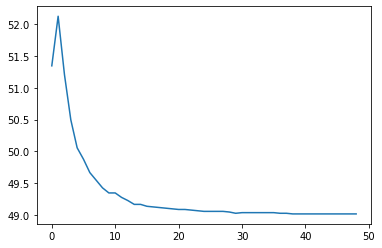





 67%|██████▋   | 4/6 [1:50:58<54:57, 1648.61s/it]  




  0%|          | 0/49 [00:00<?, ?it/s]

100000







 41%|████      | 20/49 [07:13<10:28, 21.66s/it]




 43%|████▎     | 21/49 [07:17<07:39, 16.41s/it]




 45%|████▍     | 22/49 [07:18<05:19, 11.84s/it]




 47%|████▋     | 23/49 [07:24<04:22, 10.09s/it]




 51%|█████     | 25/49 [07:29<03:07,  7.82s/it]




 53%|█████▎    | 26/49 [07:40<03:20,  8.74s/it]




 55%|█████▌    | 27/49 [07:57<04:06, 11.20s/it]




 57%|█████▋    | 28/49 [08:29<06:05, 17.41s/it]




 59%|█████▉    | 29/49 [09:50<12:10, 36.55s/it]




 61%|██████    | 30/49 [14:18<33:32, 105.94s/it]




 63%|██████▎   | 31/49 [14:19<22:20, 74.46s/it] 




 65%|██████▌   | 32/49 [14:26<15:23, 54.30s/it]




 67%|██████▋   | 33/49 [14:27<10:12, 38.25s/it]




 69%|██████▉   | 34/49 [14:32<07:04, 28.29s/it]




 71%|███████▏  | 35/49 [14:32<04:39, 19.94s/it]




 73%|███████▎  | 36/49 [14:39<03:27, 16.00s/it]




 76%|███████▌  | 37/49 [14:55<03:12, 16.05s/it]




 78%|███████▊  | 38/49 [15:22<03:30, 19.16s/it]




 80%|███████▉  | 39/49 [16:49<06:37, 39.72s/it]




 82%|

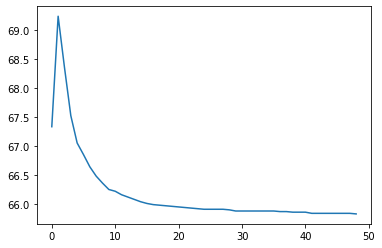





 83%|████████▎ | 5/6 [2:26:00<29:44, 1784.51s/it]




  0%|          | 0/49 [00:00<?, ?it/s]

100000







 41%|████      | 20/49 [18:41<27:06, 56.09s/it]




 43%|████▎     | 21/49 [19:26<24:33, 52.61s/it]




 45%|████▍     | 22/49 [19:31<17:14, 38.33s/it]




 47%|████▋     | 23/49 [19:36<12:16, 28.33s/it]




 49%|████▉     | 24/49 [19:49<09:50, 23.64s/it]




 51%|█████     | 25/49 [20:09<09:05, 22.73s/it]




 53%|█████▎    | 26/49 [20:45<10:14, 26.73s/it]




 55%|█████▌    | 27/49 [21:58<14:55, 40.71s/it]




 57%|█████▋    | 28/49 [23:29<19:25, 55.50s/it]




 59%|█████▉    | 29/49 [29:54<51:30, 154.54s/it]




 61%|██████    | 30/49 [37:25<1:17:06, 243.49s/it]




 63%|██████▎   | 31/49 [38:13<55:27, 184.87s/it]  




 65%|██████▌   | 32/49 [38:35<38:31, 135.99s/it]




 67%|██████▋   | 33/49 [38:42<25:57, 97.34s/it] 




 69%|██████▉   | 34/49 [38:45<17:13, 68.91s/it]




 71%|███████▏  | 35/49 [38:56<12:00, 51.49s/it]




 73%|███████▎  | 36/49 [39:25<09:40, 44.66s/it]




 76%|███████▌  | 37/49 [40:40<10:47, 53.98s/it]




 78%|███████▊  | 38/49 [42:12<11:57, 65.20s/it]




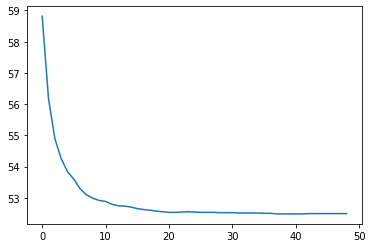





100%|██████████| 6/6 [4:01:05<00:00, 2410.84s/it]


In [28]:
for i in tqdm(np.arange(0,6,1)):
    print(len(np.unique(decay_frame_list[i].entry)))
    def get_surival_fraction_after_energy_para(z_res):
        initial_events=9999#len(np.unique(decay_frame_list[i].entry))
        data_frame=decay_frame_list[i]
        xy_res=3
        decay=decay_list[i]
        e_res1=30.98
        e_res2=12*0.37
        threshold_energy = 250
        threshold=False
        permu=True
        df_temp = energy_criteria_selection(get_data_frame_with_summed_preselected_energy_xy(data_frame,z_res,xy_res,decay,no_of_events=initial_events),decay,e_res1,e_res2,threshold_energy,threshold,permu)
        fraction = len(np.unique(df_temp.event_id))/initial_events*100
        #return df_temp
        return fraction
    start = time.time()
    fraction_list_with_xy = []
    res_start = 1
    res_end = 50
    res_step = 1
    res_list = np.arange(res_start,res_end,res_step)
    fraction_result = Parallel(n_jobs=num_cores)(delayed(get_surival_fraction_after_energy_para)(zres) for zres in tqdm(res_list))
    fraction_list_with_xy.append(fraction_result)
    #print("This process has taken %d seconds" %(end-start))  
    plt.plot(fraction_list_with_xy[0])
    plt.show()
    np.savetxt("Results_Paper/DARWIN_fraction_1_to_50_zres_in_1steps_3xy_nothreshold_%s_1_2019_11_10.txt" %(decay_list[i]),fraction_list_with_xy)





  0%|          | 0/6 [00:00<?, ?it/s]




  0%|          | 0/49 [00:00<?, ?it/s]

100000







  2%|▏         | 1/49 [00:00<00:08,  5.96it/s]




 41%|████      | 20/49 [01:25<00:42,  1.47s/it]




 43%|████▎     | 21/49 [01:26<00:33,  1.18s/it]




 45%|████▍     | 22/49 [01:26<00:24,  1.09it/s]




 47%|████▋     | 23/49 [01:27<00:23,  1.09it/s]




 49%|████▉     | 24/49 [01:28<00:24,  1.00it/s]




 51%|█████     | 25/49 [01:30<00:29,  1.23s/it]




 53%|█████▎    | 26/49 [01:31<00:30,  1.31s/it]




 55%|█████▌    | 27/49 [01:34<00:37,  1.69s/it]




 57%|█████▋    | 28/49 [01:40<01:04,  3.08s/it]




 59%|█████▉    | 29/49 [01:53<01:57,  5.89s/it]




 61%|██████    | 30/49 [02:43<06:06, 19.29s/it]




 63%|██████▎   | 31/49 [02:45<04:12, 14.01s/it]




 65%|██████▌   | 32/49 [02:45<02:48,  9.91s/it]




 67%|██████▋   | 33/49 [02:46<01:53,  7.12s/it]




 69%|██████▉   | 34/49 [02:49<01:27,  5.82s/it]




 71%|███████▏  | 35/49 [02:49<00:58,  4.19s/it]




 73%|███████▎  | 36/49 [02:49<00:39,  3.02s/it]




 76%|███████▌  | 37/49 [02:52<00:35,  2.97s/it]




 78%|███

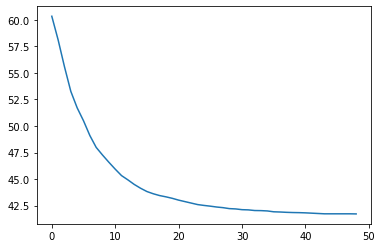





 17%|█▋        | 1/6 [06:38<33:12, 398.51s/it]




  0%|          | 0/49 [00:00<?, ?it/s]

100000







 41%|████      | 20/49 [01:03<01:31,  3.15s/it]




 43%|████▎     | 21/49 [01:03<01:06,  2.36s/it]




 45%|████▍     | 22/49 [01:03<00:45,  1.69s/it]




 47%|████▋     | 23/49 [01:03<00:32,  1.24s/it]




 49%|████▉     | 24/49 [01:05<00:32,  1.30s/it]




 51%|█████     | 25/49 [01:05<00:25,  1.06s/it]




 53%|█████▎    | 26/49 [01:07<00:29,  1.27s/it]




 55%|█████▌    | 27/49 [01:07<00:22,  1.02s/it]




 57%|█████▋    | 28/49 [01:11<00:36,  1.73s/it]




 59%|█████▉    | 29/49 [01:18<01:06,  3.33s/it]




 61%|██████    | 30/49 [02:05<05:14, 16.56s/it]




 63%|██████▎   | 31/49 [02:06<03:34, 11.91s/it]




 65%|██████▌   | 32/49 [02:07<02:23,  8.46s/it]




 67%|██████▋   | 33/49 [02:08<01:40,  6.26s/it]




 69%|██████▉   | 34/49 [02:08<01:06,  4.43s/it]




 71%|███████▏  | 35/49 [02:09<00:45,  3.25s/it]




 73%|███████▎  | 36/49 [02:10<00:34,  2.67s/it]




 76%|███████▌  | 37/49 [02:11<00:25,  2.16s/it]




 78%|███████▊  | 38/49 [02:12<00:21,  1.98s/it]




 80%|██

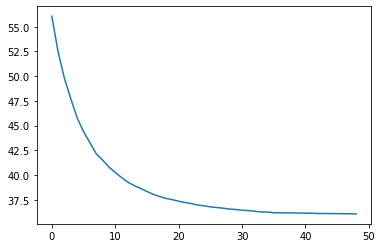





 33%|███▎      | 2/6 [11:49<24:48, 372.20s/it]




  0%|          | 0/49 [00:00<?, ?it/s]

100000







 41%|████      | 20/49 [03:27<05:01, 10.39s/it]




 43%|████▎     | 21/49 [03:29<03:39,  7.84s/it]




 45%|████▍     | 22/49 [03:38<03:40,  8.17s/it]




 47%|████▋     | 23/49 [03:47<03:34,  8.25s/it]




 49%|████▉     | 24/49 [03:57<03:45,  9.01s/it]




 51%|█████     | 25/49 [04:24<05:41, 14.22s/it]




 53%|█████▎    | 26/49 [04:58<07:45, 20.26s/it]




 55%|█████▌    | 27/49 [05:42<09:58, 27.21s/it]




 57%|█████▋    | 28/49 [06:50<13:52, 39.64s/it]




 59%|█████▉    | 29/49 [06:52<09:26, 28.32s/it]




 61%|██████    | 30/49 [06:57<06:45, 21.32s/it]




 63%|██████▎   | 31/49 [06:59<04:40, 15.56s/it]




 65%|██████▌   | 32/49 [07:11<04:04, 14.37s/it]




 67%|██████▋   | 33/49 [07:34<04:31, 16.96s/it]




 69%|██████▉   | 34/49 [07:44<03:42, 14.84s/it]




 71%|███████▏  | 35/49 [08:13<04:26, 19.04s/it]




 73%|███████▎  | 36/49 [08:50<05:17, 24.45s/it]




 76%|███████▌  | 37/49 [09:57<07:28, 37.35s/it]




 78%|███████▊  | 38/49 [10:04<05:11, 28.30s/it]




 80%|██

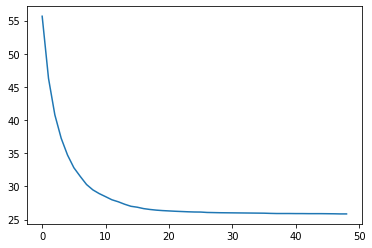





 50%|█████     | 3/6 [29:47<29:12, 584.06s/it]




  0%|          | 0/49 [00:00<?, ?it/s]

100000







 41%|████      | 20/49 [02:53<04:11,  8.68s/it]




 43%|████▎     | 21/49 [02:59<03:35,  7.69s/it]




 45%|████▍     | 22/49 [03:05<03:17,  7.30s/it]




 47%|████▋     | 23/49 [03:13<03:12,  7.40s/it]




 49%|████▉     | 24/49 [03:25<03:40,  8.84s/it]




 51%|█████     | 25/49 [03:29<02:58,  7.43s/it]




 53%|█████▎    | 26/49 [03:55<04:58, 12.99s/it]




 55%|█████▌    | 27/49 [04:35<07:48, 21.28s/it]




 57%|█████▋    | 28/49 [05:37<11:39, 33.29s/it]




 59%|█████▉    | 29/49 [05:44<08:28, 25.43s/it]




 61%|██████    | 30/49 [05:48<06:02, 19.06s/it]




 63%|██████▎   | 31/49 [05:49<04:06, 13.67s/it]




 65%|██████▌   | 32/49 [06:00<03:38, 12.87s/it]




 67%|██████▋   | 33/49 [06:08<02:59, 11.21s/it]




 69%|██████▉   | 34/49 [06:09<02:02,  8.15s/it]




 71%|███████▏  | 35/49 [06:34<03:07, 13.36s/it]




 73%|███████▎  | 36/49 [07:11<04:26, 20.48s/it]




 76%|███████▌  | 37/49 [07:21<03:27, 17.33s/it]




 78%|███████▊  | 38/49 [08:16<05:14, 28.58s/it]




 80%|██

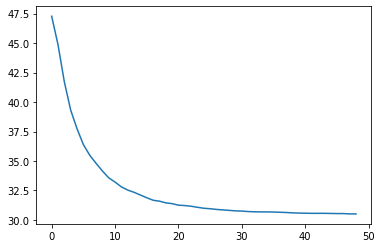





 67%|██████▋   | 4/6 [44:40<22:33, 676.56s/it]




  0%|          | 0/49 [00:00<?, ?it/s]

100000







 41%|████      | 20/49 [02:45<04:00,  8.29s/it]




 43%|████▎     | 21/49 [02:51<03:30,  7.53s/it]




 45%|████▍     | 22/49 [02:53<02:38,  5.86s/it]




 47%|████▋     | 23/49 [03:01<02:49,  6.50s/it]




 49%|████▉     | 24/49 [03:12<03:16,  7.87s/it]




 51%|█████     | 25/49 [03:24<03:38,  9.12s/it]




 53%|█████▎    | 26/49 [03:41<04:25, 11.56s/it]




 55%|█████▌    | 27/49 [04:16<06:46, 18.47s/it]




 57%|█████▋    | 28/49 [05:11<10:16, 29.34s/it]




 59%|█████▉    | 29/49 [05:30<08:44, 26.22s/it]




 61%|██████    | 30/49 [05:31<05:55, 18.71s/it]




 63%|██████▎   | 31/49 [05:32<04:03, 13.52s/it]




 65%|██████▌   | 32/49 [05:37<03:05, 10.89s/it]




 67%|██████▋   | 33/49 [05:51<03:10, 11.92s/it]




 69%|██████▉   | 34/49 [05:54<02:17,  9.18s/it]




 71%|███████▏  | 35/49 [06:13<02:48, 12.03s/it]




 73%|███████▎  | 36/49 [06:47<04:04, 18.77s/it]




 76%|███████▌  | 37/49 [06:53<02:59, 14.92s/it]




 78%|███████▊  | 38/49 [07:42<04:35, 25.01s/it]




 80%|██

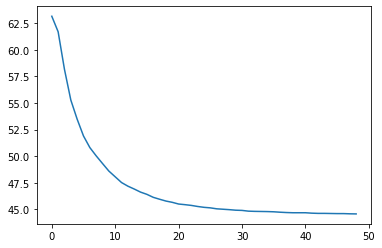





 83%|████████▎ | 5/6 [58:55<12:10, 730.08s/it]




  0%|          | 0/49 [00:00<?, ?it/s]

100000







 41%|████      | 20/49 [05:40<08:13, 17.00s/it]




 43%|████▎     | 21/49 [05:51<07:11, 15.43s/it]




 45%|████▍     | 22/49 [06:09<07:17, 16.20s/it]




 47%|████▋     | 23/49 [06:23<06:37, 15.31s/it]




 49%|████▉     | 24/49 [06:53<08:18, 19.92s/it]




 51%|█████     | 25/49 [07:33<10:18, 25.78s/it]




 53%|█████▎    | 26/49 [08:27<13:11, 34.40s/it]




 55%|█████▌    | 27/49 [10:13<20:27, 55.78s/it]




 57%|█████▋    | 28/49 [11:02<18:52, 53.93s/it]




 59%|█████▉    | 29/49 [11:14<13:46, 41.31s/it]




 61%|██████    | 30/49 [11:35<11:08, 35.20s/it]




 63%|██████▎   | 31/49 [11:41<07:54, 26.35s/it]




 65%|██████▌   | 32/49 [12:10<07:40, 27.10s/it]




 67%|██████▋   | 33/49 [12:52<08:24, 31.52s/it]




 69%|██████▉   | 34/49 [13:27<08:08, 32.54s/it]




 71%|███████▏  | 35/49 [13:45<06:35, 28.23s/it]




 73%|███████▎  | 36/49 [15:35<11:27, 52.92s/it]




 76%|███████▌  | 37/49 [16:21<10:08, 50.72s/it]




 78%|███████▊  | 38/49 [16:30<07:01, 38.30s/it]




 80%|██

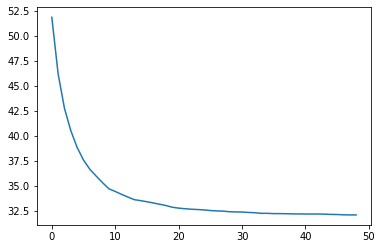





100%|██████████| 6/6 [1:28:14<00:00, 882.38s/it] 


In [29]:
for i in tqdm(np.arange(0,6,1)):
    print(len(np.unique(decay_frame_list[i].entry)))
    def get_surival_fraction_after_energy_para(z_res):
        initial_events=9999#len(np.unique(decay_frame_list[i].entry))
        data_frame=decay_frame_list[i]
        xy_res=10
        decay=decay_list[i]
        e_res1=30.98
        e_res2=12*0.37
        threshold_energy = 250
        threshold=False
        permu=True
        df_temp = energy_criteria_selection(get_data_frame_with_summed_preselected_energy_xy(data_frame,z_res,xy_res,decay,no_of_events=initial_events),decay,e_res1,e_res2,threshold_energy,threshold,permu)
        fraction = len(np.unique(df_temp.event_id))/initial_events*100
        #return df_temp
        return fraction
    start = time.time()
    fraction_list_with_xy = []
    res_start = 1
    res_end = 50
    res_step = 1
    res_list = np.arange(res_start,res_end,res_step)
    fraction_result = Parallel(n_jobs=num_cores)(delayed(get_surival_fraction_after_energy_para)(zres) for zres in tqdm(res_list))
    fraction_list_with_xy.append(fraction_result)
    #print("This process has taken %d seconds" %(end-start))  
    plt.plot(fraction_list_with_xy[0])
    plt.show()
    np.savetxt("Results_Paper/DARWIN_fraction_1_to_50_zres_in_1steps_10xy_nothreshold_%s_1_2019_11_10.txt" %(decay_list[i]),fraction_list_with_xy)





  0%|          | 0/6 [00:00<?, ?it/s]




  0%|          | 0/49 [00:00<?, ?it/s]

100000







 41%|████      | 20/49 [01:03<01:32,  3.19s/it]




 43%|████▎     | 21/49 [01:05<01:13,  2.63s/it]




 45%|████▍     | 22/49 [01:07<01:07,  2.48s/it]




 47%|████▋     | 23/49 [01:07<00:48,  1.85s/it]




 49%|████▉     | 24/49 [01:09<00:48,  1.95s/it]




 51%|█████     | 25/49 [01:14<01:04,  2.71s/it]




 53%|█████▎    | 26/49 [01:15<00:55,  2.40s/it]




 55%|█████▌    | 27/49 [01:21<01:14,  3.39s/it]




 57%|█████▋    | 28/49 [01:26<01:20,  3.84s/it]




 59%|█████▉    | 29/49 [01:39<02:10,  6.55s/it]




 61%|██████    | 30/49 [02:06<04:00, 12.66s/it]




 63%|██████▎   | 31/49 [02:06<02:41,  8.97s/it]




 65%|██████▌   | 32/49 [02:08<01:57,  6.91s/it]




 67%|██████▋   | 33/49 [02:10<01:26,  5.44s/it]




 69%|██████▉   | 34/49 [02:11<00:59,  4.00s/it]




 71%|███████▏  | 35/49 [02:14<00:54,  3.87s/it]




 73%|███████▎  | 36/49 [02:15<00:37,  2.87s/it]




 76%|███████▌  | 37/49 [02:22<00:50,  4.21s/it]




 78%|███████▊  | 38/49 [02:25<00:42,  3.86s/it]




 80%|██

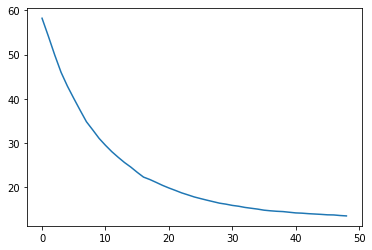





 17%|█▋        | 1/6 [05:05<25:27, 305.48s/it]




  0%|          | 0/49 [00:00<?, ?it/s]

100000







 41%|████      | 20/49 [00:54<01:19,  2.74s/it]




 43%|████▎     | 21/49 [00:56<01:04,  2.31s/it]




 45%|████▍     | 22/49 [00:57<00:51,  1.90s/it]




 47%|████▋     | 23/49 [00:57<00:40,  1.54s/it]




 49%|████▉     | 24/49 [00:58<00:30,  1.23s/it]




 51%|█████     | 25/49 [00:59<00:27,  1.15s/it]




 53%|█████▎    | 26/49 [01:00<00:29,  1.29s/it]




 55%|█████▌    | 27/49 [01:02<00:31,  1.45s/it]




 57%|█████▋    | 28/49 [01:06<00:43,  2.08s/it]




 59%|█████▉    | 29/49 [01:14<01:17,  3.87s/it]




 61%|██████    | 30/49 [01:48<04:08, 13.06s/it]




 63%|██████▎   | 31/49 [01:49<02:49,  9.42s/it]




 65%|██████▌   | 32/49 [01:50<01:54,  6.74s/it]




 67%|██████▋   | 33/49 [01:50<01:17,  4.86s/it]




 69%|██████▉   | 34/49 [01:51<00:53,  3.60s/it]




 71%|███████▏  | 35/49 [01:51<00:37,  2.67s/it]




 73%|███████▎  | 36/49 [01:52<00:26,  2.02s/it]




 76%|███████▌  | 37/49 [01:54<00:24,  2.06s/it]




 78%|███████▊  | 38/49 [01:56<00:21,  1.93s/it]




 80%|██

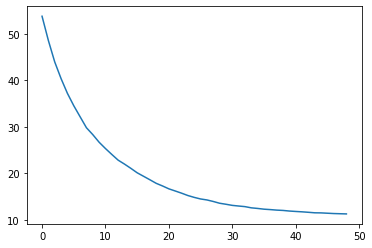





 33%|███▎      | 2/6 [09:24<19:25, 291.48s/it]




  0%|          | 0/49 [00:00<?, ?it/s]

100000







 41%|████      | 20/49 [01:29<02:09,  4.46s/it]




 43%|████▎     | 21/49 [01:32<01:55,  4.12s/it]




 45%|████▍     | 22/49 [01:35<01:39,  3.67s/it]




 47%|████▋     | 23/49 [01:45<02:24,  5.56s/it]




 49%|████▉     | 24/49 [01:52<02:31,  6.05s/it]




 51%|█████     | 25/49 [02:07<03:30,  8.76s/it]




 53%|█████▎    | 26/49 [02:27<04:41, 12.23s/it]




 55%|█████▌    | 27/49 [02:57<06:23, 17.42s/it]




 57%|█████▋    | 28/49 [02:58<04:26, 12.68s/it]




 59%|█████▉    | 29/49 [02:59<03:00,  9.04s/it]




 61%|██████    | 30/49 [03:08<02:53,  9.11s/it]




 63%|██████▎   | 31/49 [03:12<02:15,  7.55s/it]




 65%|██████▌   | 32/49 [03:13<01:33,  5.49s/it]




 67%|██████▋   | 33/49 [03:28<02:15,  8.49s/it]




 69%|██████▉   | 34/49 [03:47<02:55, 11.69s/it]




 71%|███████▏  | 35/49 [04:18<04:03, 17.40s/it]




 76%|███████▌  | 37/49 [04:20<02:29, 12.46s/it]




 78%|███████▊  | 38/49 [04:28<02:00, 10.98s/it]




 80%|███████▉  | 39/49 [04:32<01:29,  9.00s/it]




 82%|██

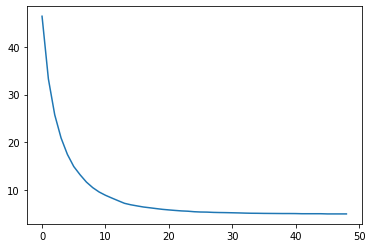





 50%|█████     | 3/6 [18:11<18:06, 362.27s/it]




  0%|          | 0/49 [00:00<?, ?it/s]

100000







 41%|████      | 20/49 [01:30<02:11,  4.53s/it]




 43%|████▎     | 21/49 [01:33<01:54,  4.10s/it]




 45%|████▍     | 22/49 [01:35<01:31,  3.39s/it]




 47%|████▋     | 23/49 [01:41<01:51,  4.30s/it]




 49%|████▉     | 24/49 [01:49<02:16,  5.46s/it]




 51%|█████     | 25/49 [01:59<02:40,  6.67s/it]




 53%|█████▎    | 26/49 [02:16<03:45,  9.79s/it]




 55%|█████▌    | 27/49 [02:40<05:10, 14.11s/it]




 57%|█████▋    | 28/49 [02:57<05:14, 14.95s/it]




 59%|█████▉    | 29/49 [02:58<03:35, 10.78s/it]




 61%|██████    | 30/49 [02:59<02:25,  7.68s/it]




 63%|██████▎   | 31/49 [03:03<02:01,  6.74s/it]




 65%|██████▌   | 32/49 [03:09<01:51,  6.54s/it]




 67%|██████▋   | 33/49 [03:18<01:54,  7.13s/it]




 69%|██████▉   | 34/49 [03:33<02:22,  9.53s/it]




 71%|███████▏  | 35/49 [03:44<02:20, 10.05s/it]




 73%|███████▎  | 36/49 [03:58<02:26, 11.26s/it]




 76%|███████▌  | 37/49 [04:14<02:29, 12.48s/it]




 78%|███████▊  | 38/49 [04:15<01:41,  9.26s/it]




 80%|██

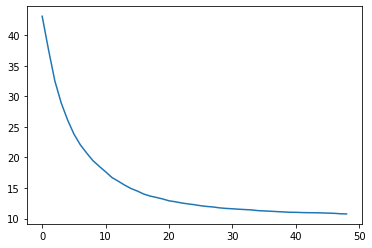





 67%|██████▋   | 4/6 [25:40<12:56, 388.07s/it]




  0%|          | 0/49 [00:00<?, ?it/s]

100000







 41%|████      | 20/49 [01:28<02:08,  4.43s/it]




 43%|████▎     | 21/49 [01:32<01:56,  4.15s/it]




 45%|████▍     | 22/49 [01:33<01:29,  3.31s/it]




 47%|████▋     | 23/49 [01:37<01:33,  3.61s/it]




 49%|████▉     | 24/49 [01:46<02:04,  4.98s/it]




 51%|█████     | 25/49 [01:53<02:17,  5.73s/it]




 53%|█████▎    | 26/49 [02:10<03:28,  9.07s/it]




 55%|█████▌    | 27/49 [02:36<05:14, 14.28s/it]




 57%|█████▋    | 28/49 [02:54<05:22, 15.34s/it]




 59%|█████▉    | 29/49 [02:56<03:43, 11.17s/it]




 61%|██████    | 30/49 [02:56<02:33,  8.07s/it]




 63%|██████▎   | 31/49 [02:57<01:46,  5.94s/it]




 65%|██████▌   | 32/49 [03:06<01:53,  6.67s/it]




 67%|██████▋   | 33/49 [03:11<01:39,  6.22s/it]




 69%|██████▉   | 34/49 [03:27<02:16,  9.09s/it]




 71%|███████▏  | 35/49 [03:36<02:09,  9.28s/it]




 73%|███████▎  | 36/49 [03:55<02:36, 12.03s/it]




 76%|███████▌  | 37/49 [04:08<02:29, 12.47s/it]




 78%|███████▊  | 38/49 [04:11<01:43,  9.43s/it]




 80%|██

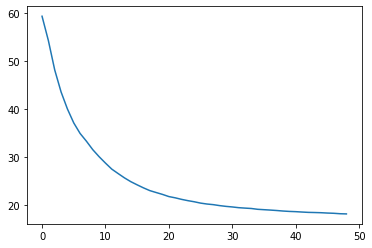





 83%|████████▎ | 5/6 [33:06<06:45, 405.46s/it]




  0%|          | 0/49 [00:00<?, ?it/s]

100000







 41%|████      | 20/49 [02:16<03:18,  6.85s/it]




 43%|████▎     | 21/49 [02:17<02:22,  5.10s/it]




 45%|████▍     | 22/49 [02:26<02:49,  6.27s/it]




 47%|████▋     | 23/49 [02:39<03:35,  8.30s/it]




 49%|████▉     | 24/49 [02:53<04:05,  9.83s/it]




 51%|█████     | 25/49 [03:11<04:58, 12.43s/it]




 53%|█████▎    | 26/49 [03:52<07:58, 20.81s/it]




 55%|█████▌    | 27/49 [04:23<08:44, 23.83s/it]




 57%|█████▋    | 28/49 [04:27<06:16, 17.91s/it]




 59%|█████▉    | 29/49 [04:29<04:22, 13.14s/it]




 61%|██████    | 30/49 [04:42<04:08, 13.07s/it]




 63%|██████▎   | 31/49 [04:54<03:53, 12.96s/it]




 65%|██████▌   | 32/49 [04:57<02:48,  9.91s/it]




 67%|██████▋   | 33/49 [05:08<02:44, 10.25s/it]




 69%|██████▉   | 34/49 [05:49<04:52, 19.47s/it]




 71%|███████▏  | 35/49 [06:18<05:12, 22.30s/it]




 73%|███████▎  | 36/49 [06:23<03:41, 17.01s/it]




 76%|███████▌  | 37/49 [06:23<02:25, 12.14s/it]




 78%|███████▊  | 38/49 [06:36<02:14, 12.22s/it]




 80%|██

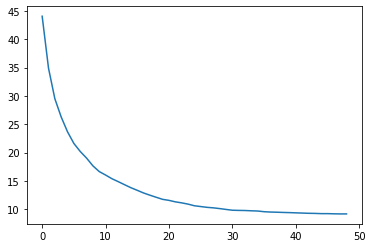





100%|██████████| 6/6 [46:40<00:00, 466.80s/it]


In [30]:
for i in tqdm(np.arange(0,6,1)):
    print(len(np.unique(decay_frame_list[i].entry)))
    def get_surival_fraction_after_energy_para(z_res):
        initial_events=9999#len(np.unique(decay_frame_list[i].entry))
        data_frame=decay_frame_list[i]
        xy_res=30
        decay=decay_list[i]
        e_res1=30.98
        e_res2=12*0.37
        threshold_energy = 250
        threshold=False
        permu=True
        df_temp = energy_criteria_selection(get_data_frame_with_summed_preselected_energy_xy(data_frame,z_res,xy_res,decay,no_of_events=initial_events),decay,e_res1,e_res2,threshold_energy,threshold,permu)
        fraction = len(np.unique(df_temp.event_id))/initial_events*100
        #return df_temp
        return fraction
    start = time.time()
    fraction_list_with_xy = []
    res_start = 1
    res_end = 50
    res_step = 1
    res_list = np.arange(res_start,res_end,res_step)
    fraction_result = Parallel(n_jobs=num_cores)(delayed(get_surival_fraction_after_energy_para)(zres) for zres in tqdm(res_list))
    fraction_list_with_xy.append(fraction_result)
    #print("This process has taken %d seconds" %(end-start))  
    plt.plot(fraction_list_with_xy[0])
    plt.show()
    np.savetxt("Results_Paper/DARWIN_fraction_1_to_50_zres_in_1steps_30xy_nothreshold_%s_1_2019_11_10.txt" %(decay_list[i]),fraction_list_with_xy)





  0%|          | 0/6 [00:00<?, ?it/s]




  0%|          | 0/49 [00:00<?, ?it/s]

100000







 41%|████      | 20/49 [01:00<01:27,  3.02s/it]




 43%|████▎     | 21/49 [01:02<01:17,  2.77s/it]




 45%|████▍     | 22/49 [01:04<01:10,  2.61s/it]




 47%|████▋     | 23/49 [01:06<01:01,  2.35s/it]




 49%|████▉     | 24/49 [01:08<00:53,  2.13s/it]




 51%|█████     | 25/49 [01:10<00:54,  2.25s/it]




 53%|█████▎    | 26/49 [01:12<00:49,  2.14s/it]




 55%|█████▌    | 27/49 [01:17<01:02,  2.83s/it]




 57%|█████▋    | 28/49 [01:24<01:25,  4.08s/it]




 59%|█████▉    | 29/49 [01:38<02:22,  7.14s/it]




 61%|██████    | 30/49 [01:57<03:26, 10.89s/it]




 63%|██████▎   | 31/49 [01:58<02:19,  7.77s/it]




 65%|██████▌   | 32/49 [01:59<01:39,  5.84s/it]




 69%|██████▉   | 34/49 [02:01<01:06,  4.41s/it]




 71%|███████▏  | 35/49 [02:02<00:45,  3.23s/it]




 73%|███████▎  | 36/49 [02:03<00:33,  2.56s/it]




 76%|███████▌  | 37/49 [02:06<00:32,  2.75s/it]




 78%|███████▊  | 38/49 [02:14<00:47,  4.33s/it]




 80%|███████▉  | 39/49 [02:27<01:07,  6.78s/it]




 82%|██

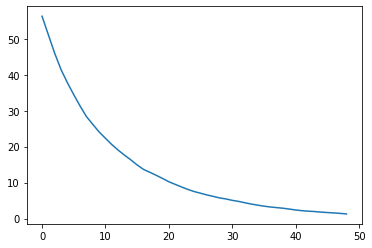





 17%|█▋        | 1/6 [04:27<22:17, 267.59s/it]




  0%|          | 0/49 [00:00<?, ?it/s]

100000







 41%|████      | 20/49 [00:53<01:18,  2.69s/it]




 43%|████▎     | 21/49 [00:54<01:00,  2.17s/it]




 45%|████▍     | 22/49 [00:55<00:48,  1.81s/it]




 47%|████▋     | 23/49 [00:57<00:43,  1.69s/it]




 49%|████▉     | 24/49 [00:59<00:44,  1.76s/it]




 51%|█████     | 25/49 [00:59<00:32,  1.36s/it]




 53%|█████▎    | 26/49 [01:00<00:26,  1.13s/it]




 55%|█████▌    | 27/49 [01:03<00:37,  1.72s/it]




 57%|█████▋    | 28/49 [01:07<00:53,  2.54s/it]




 59%|█████▉    | 29/49 [01:13<01:09,  3.47s/it]




 61%|██████    | 30/49 [01:47<03:58, 12.57s/it]




 63%|██████▎   | 31/49 [01:48<02:44,  9.15s/it]




 65%|██████▌   | 32/49 [01:49<01:53,  6.67s/it]




 67%|██████▋   | 33/49 [01:49<01:16,  4.80s/it]




 69%|██████▉   | 34/49 [01:49<00:51,  3.43s/it]




 71%|███████▏  | 35/49 [01:51<00:40,  2.91s/it]




 73%|███████▎  | 36/49 [01:52<00:29,  2.27s/it]




 76%|███████▌  | 37/49 [01:53<00:22,  1.87s/it]




 78%|███████▊  | 38/49 [01:58<00:32,  2.93s/it]




 80%|██

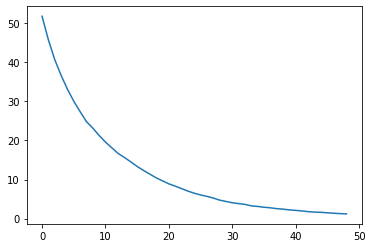





 33%|███▎      | 2/6 [08:42<17:34, 263.73s/it]




  0%|          | 0/49 [00:00<?, ?it/s]

100000







 41%|████      | 20/49 [01:11<01:43,  3.57s/it]




 43%|████▎     | 21/49 [01:13<01:30,  3.24s/it]




 45%|████▍     | 22/49 [01:15<01:14,  2.76s/it]




 47%|████▋     | 23/49 [01:16<00:54,  2.11s/it]




 49%|████▉     | 24/49 [01:18<00:57,  2.30s/it]




 51%|█████     | 25/49 [01:23<01:11,  2.99s/it]




 53%|█████▎    | 26/49 [01:38<02:33,  6.67s/it]




 55%|█████▌    | 27/49 [02:04<04:29, 12.26s/it]




 57%|█████▋    | 28/49 [02:22<04:53, 13.99s/it]




 59%|█████▉    | 29/49 [02:24<03:30, 10.55s/it]




 61%|██████    | 30/49 [02:25<02:23,  7.58s/it]




 65%|██████▌   | 32/49 [02:26<01:32,  5.43s/it]




 67%|██████▋   | 33/49 [02:30<01:22,  5.13s/it]




 69%|██████▉   | 34/49 [02:46<02:05,  8.39s/it]




 71%|███████▏  | 35/49 [03:04<02:39, 11.41s/it]




 73%|███████▎  | 36/49 [03:11<02:07,  9.84s/it]




 76%|███████▌  | 37/49 [03:31<02:35, 12.94s/it]




 78%|███████▊  | 38/49 [03:33<01:45,  9.58s/it]




 80%|███████▉  | 39/49 [03:33<01:09,  6.98s/it]




 82%|██

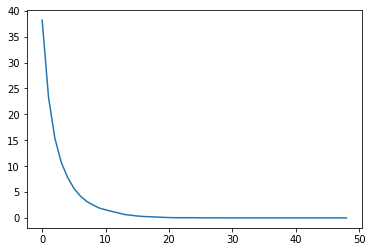





 50%|█████     | 3/6 [15:20<15:11, 304.00s/it]




  0%|          | 0/49 [00:00<?, ?it/s]

100000







 41%|████      | 20/49 [01:11<01:44,  3.59s/it]




 43%|████▎     | 21/49 [01:15<01:39,  3.56s/it]




 45%|████▍     | 22/49 [01:16<01:14,  2.75s/it]




 47%|████▋     | 23/49 [01:19<01:18,  3.02s/it]




 49%|████▉     | 24/49 [01:21<01:04,  2.59s/it]




 51%|█████     | 25/49 [01:27<01:29,  3.75s/it]




 53%|█████▎    | 26/49 [01:36<02:03,  5.36s/it]




 55%|█████▌    | 27/49 [01:55<03:28,  9.47s/it]




 57%|█████▋    | 28/49 [02:18<04:40, 13.36s/it]




 59%|█████▉    | 29/49 [02:21<03:25, 10.28s/it]




 61%|██████    | 30/49 [02:21<02:19,  7.34s/it]




 63%|██████▎   | 31/49 [02:24<01:44,  5.81s/it]




 65%|██████▌   | 32/49 [02:25<01:13,  4.34s/it]




 67%|██████▋   | 33/49 [02:31<01:17,  4.81s/it]




 69%|██████▉   | 34/49 [02:38<01:25,  5.67s/it]




 71%|███████▏  | 35/49 [02:39<00:58,  4.16s/it]




 73%|███████▎  | 36/49 [02:59<01:57,  9.06s/it]




 76%|███████▌  | 37/49 [03:21<02:32, 12.72s/it]




 78%|███████▊  | 38/49 [03:24<01:50, 10.04s/it]




 80%|██

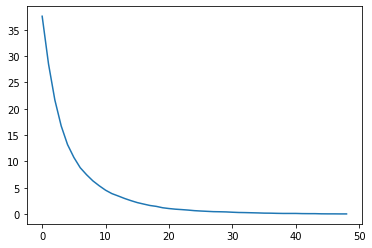





 67%|██████▋   | 4/6 [21:21<10:42, 321.20s/it]




  0%|          | 0/49 [00:00<?, ?it/s]

100000







 41%|████      | 20/49 [01:08<01:38,  3.41s/it]




 43%|████▎     | 21/49 [01:08<01:08,  2.45s/it]




 45%|████▍     | 22/49 [01:10<00:59,  2.22s/it]




 47%|████▋     | 23/49 [01:13<01:06,  2.57s/it]




 49%|████▉     | 24/49 [01:18<01:24,  3.40s/it]




 51%|█████     | 25/49 [01:19<01:04,  2.68s/it]




 53%|█████▎    | 26/49 [01:28<01:46,  4.62s/it]




 55%|█████▌    | 27/49 [01:46<03:09,  8.60s/it]




 57%|█████▋    | 28/49 [02:12<04:45, 13.61s/it]




 59%|█████▉    | 29/49 [02:13<03:19,  9.97s/it]




 61%|██████    | 30/49 [02:16<02:31,  7.96s/it]




 63%|██████▎   | 31/49 [02:19<01:53,  6.31s/it]




 65%|██████▌   | 32/49 [02:22<01:33,  5.50s/it]




 67%|██████▋   | 33/49 [02:24<01:08,  4.25s/it]




 69%|██████▉   | 34/49 [02:26<00:55,  3.73s/it]




 71%|███████▏  | 35/49 [02:31<00:57,  4.11s/it]




 73%|███████▎  | 36/49 [02:51<01:52,  8.67s/it]




 76%|███████▌  | 37/49 [03:14<02:35, 12.98s/it]




 78%|███████▊  | 38/49 [03:15<01:44,  9.51s/it]




 80%|██

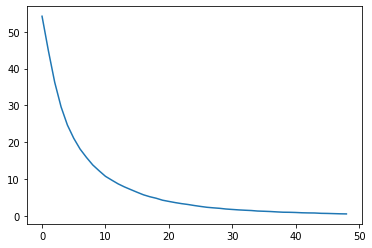





 83%|████████▎ | 5/6 [27:15<05:31, 331.07s/it]




  0%|          | 0/49 [00:00<?, ?it/s]

100000







 41%|████      | 20/49 [01:26<02:05,  4.34s/it]




 43%|████▎     | 21/49 [01:28<01:38,  3.53s/it]




 45%|████▍     | 22/49 [01:33<01:45,  3.89s/it]




 47%|████▋     | 23/49 [01:38<01:55,  4.44s/it]




 49%|████▉     | 24/49 [01:42<01:46,  4.24s/it]




 51%|█████     | 25/49 [01:54<02:37,  6.56s/it]




 53%|█████▎    | 26/49 [02:10<03:35,  9.39s/it]




 55%|█████▌    | 27/49 [02:44<06:09, 16.79s/it]




 57%|█████▋    | 28/49 [02:50<04:44, 13.55s/it]




 59%|█████▉    | 29/49 [02:51<03:15,  9.78s/it]




 61%|██████    | 30/49 [02:53<02:21,  7.43s/it]




 63%|██████▎   | 31/49 [02:59<02:06,  7.05s/it]




 65%|██████▌   | 32/49 [03:00<01:26,  5.11s/it]




 67%|██████▋   | 33/49 [03:14<02:06,  7.93s/it]




 69%|██████▉   | 34/49 [03:29<02:28,  9.90s/it]




 71%|███████▏  | 35/49 [04:05<04:06, 17.61s/it]




 73%|███████▎  | 36/49 [04:08<02:54, 13.45s/it]




 76%|███████▌  | 37/49 [04:09<01:54,  9.51s/it]




 78%|███████▊  | 38/49 [04:10<01:17,  7.02s/it]




 80%|██

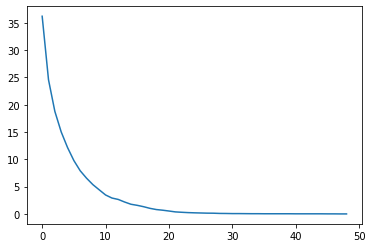





100%|██████████| 6/6 [36:03<00:00, 360.53s/it]


In [31]:
for i in tqdm(np.arange(0,6,1)):
    print(len(np.unique(decay_frame_list[i].entry)))
    def get_surival_fraction_after_energy_para(z_res):
        initial_events=9999#len(np.unique(decay_frame_list[i].entry))
        data_frame=decay_frame_list[i]
        xy_res=50000
        decay=decay_list[i]
        e_res1=30.98
        e_res2=12*0.37
        threshold_energy = 250
        threshold=False
        permu=True
        df_temp = energy_criteria_selection(get_data_frame_with_summed_energy_xy(data_frame,z_res,xy_res,no_of_events=initial_events),decay,e_res1,e_res2,threshold_energy,threshold,permu)
        fraction = len(np.unique(df_temp.event_id))/initial_events*100
        #return df_temp
        return fraction
    start = time.time()
    fraction_list_with_xy = []
    res_start = 1
    res_end = 50
    res_step = 1
    res_list = np.arange(res_start,res_end,res_step)
    fraction_result = Parallel(n_jobs=num_cores)(delayed(get_surival_fraction_after_energy_para)(zres) for zres in tqdm(res_list))
    fraction_list_with_xy.append(fraction_result)
    #print("This process has taken %d seconds" %(end-start))  
    plt.plot(fraction_list_with_xy[0])
    plt.show()
    np.savetxt("Results_Paper/DARWIN_fraction_1_to_50_zres_in_1steps_noxy_nothreshold_%s_1_2019_11_10.txt" %(decay_list[i]),fraction_list_with_xy)

### Cross check on the energy resolution dependence ###


In [35]:
def get_surival_fraction_after_energy_para(e_res1):
    initial_events=10933
    data_frame=df_bkg
    xy_res=3
    z_res=1
    decay="2vECB+"
    #e_res1=90.98
    e_res2=0.3
    threshold_energy=250
    threshold=False
    permu=True
    df_temp = energy_criteria_selection(get_data_frame_with_summed_energy_xy(data_frame,z_res,xy_res,no_of_events=initial_events),decay,e_res1,e_res2,threshold_energy,threshold,permu)
    fraction = len(np.unique(df_temp.event_id))/initial_events*100
    #return df_temp
    return fraction

In [36]:
start = time.time()
num_cores=10
fraction_list_with_xy = []
res_start = 20
res_end = 200
res_step = 5
res_list = np.arange(res_start,res_end,res_step)
fraction_result = Parallel(n_jobs=num_cores)(delayed(get_surival_fraction_after_energy_para)(e_res1) for e_res1 in tqdm(res_list))
fraction_list_with_xy.append(fraction_result)
end= time.time()
print("This process has taken %d seconds" %(end-start))  




  0%|          | 0/36 [00:00<?, ?it/s]

 56%|█████▌    | 20/36 [00:21<00:16,  1.06s/it]

 58%|█████▊    | 21/36 [00:21<00:11,  1.27it/s]

 61%|██████    | 22/36 [00:21<00:08,  1.62it/s]

 69%|██████▉   | 25/36 [00:21<00:04,  2.24it/s]

 75%|███████▌  | 27/36 [00:21<00:03,  2.88it/s]

 81%|████████  | 29/36 [00:22<00:01,  3.82it/s]

 81%|████████  | 29/36 [00:32<00:01,  3.82it/s]

 83%|████████▎ | 30/36 [00:44<00:41,  6.85s/it]

 86%|████████▌ | 31/36 [00:44<00:24,  4.98s/it]

 89%|████████▉ | 32/36 [00:45<00:14,  3.55s/it]

 92%|█████████▏| 33/36 [00:45<00:07,  2.59s/it]

 94%|█████████▍| 34/36 [00:45<00:03,  1.84s/it]

 97%|█████████▋| 35/36 [00:45<00:01,  1.32s/it]

100%|██████████| 36/36 [00:45<00:00,  1.27s/it]

This process has taken 84929 seconds


In [37]:
fraction_list_with_xy

[[0.38415805359919514,
  0.4207445348943566,
  0.42989115521814686,
  0.4390377755419373,
  0.457331016189518,
  0.4939174974846794,
  0.5305039787798408,
  0.5396505991036312,
  0.5396505991036312,
  0.5487972194274215,
  0.5945303210463734,
  0.6219701820177445,
  0.6768499039604866,
  0.713436385255648,
  0.7408762462270191,
  0.7683161071983903,
  0.8049025884935517,
  0.8323424494649228,
  0.8506356901125034,
  0.8872221714076648,
  0.9238086527028263,
  0.9603951339979877,
  0.9878349949693588,
  1.1341809201500046,
  1.1616207811213757,
  1.2073538827403274,
  1.243940364035489,
  1.2896734656544406,
  1.3445531875971828,
  1.3811396688923443,
  1.3994329095399252,
  1.426872770511296,
  1.4908991127778286,
  1.5091923534254092,
  1.582365316015732,
  1.6189517973108938]]

In [34]:
#np.savetxt("Results_Paper/worse_res_fraction_bkg_1_to_50_z_3_xy_in4steps_2vecb+_2019_09_28.txt",fraction_list_with_xy)

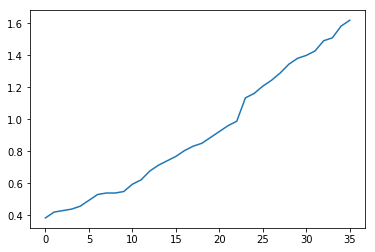

In [39]:
plt.plot(fraction_list_with_xy[0])